# 14 - Extracting a sourcelist

This is a notebook example of how to grab aperture summed spectra for an input list of ID, RA, DECs using `Extract()` from `HETDEX_API`. An array of wavelengths is optional for this notebook in case you would like to inspect spectra around a specific wavelength. Eventually we can make this a command line routine. The notebook here is for developing and testing. Contact Erin with questions and isssues.

#### Import all necessary python packages. 
For those using Python3, it is necessary to point to the HETDEX_API path. You can either use Erin's or your own git clone if you prefer.

In [1]:
import sys
sys.path.append('/work/05350/ecooper/stampede2/HETDEX_API/') 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pickle

from input_utils import setup_logging
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from hetdex_api.extract import Extract
from hetdex_api.survey import Survey
from hetdex_api.shot import *

# modules for multiprocessing, timing and manager shared dictionaries
from multiprocessing import Pool, Process, Manager
import time

log = setup_logging('3dhst')
log.info('Loading Survey')
survey = Survey('hdr1')
t = Table(survey.hdfile.root.Survey[:])

[INFO - 2019-07-05 11:46:58,807] Loading Survey


Load in a text file, map columns accordingly and build an astropy coords object.

In [3]:
log.info('Loading External File')
#table_in = Table.read('/work/04312/wpbowman/stampede2/catalogs/bowman2019_full.dat', format='ascii')
table_in = Table.read('/work/05350/ecooper/stampede2/3dhst/3dhst_input.cat', format='ascii')

log.info('Sources to extract: %s' % np.size(table_in))
ID = table_in['photID']
ra = table_in['ra']
dec = table_in['dec']

## for line fitting later.. not necessary for basic aperture extraction
wave = table_in['wave']

coords = SkyCoord(ra*u.deg, dec*u.deg)

[INFO - 2019-07-05 11:47:05,041] Loading External File
[INFO - 2019-07-05 11:47:05,049] Sources to extract: 1282


### Initialize the Extract Class from HETDEX_API and set up some initial parameters

In [4]:
E = Extract()

# Build aperture PSF for aperture extraction
fixed_aperture = 4.

# this radius applies to the inital shot search and requires a large aperture for the wide FOV of VIRUS
max_sep = 11.0 * u.arcminute

# Using box size of 10.5 (length of box side) and pixel scale of 0.25
# To see documentation use: help(E.tophat_psf)
aperture = E.tophat_psf(fixed_aperture, 10.5, 0.25)

Begin by mapping each source to each shot so we can efficiently grab fibers. This stores a dictionary of object indexes for each observation as well as a list of shots to iterate over.

In [5]:
matched_sources = {}
shots_of_interest = []

log.info('Finding shots of interest')
for i, coord in enumerate(survey.coords):
    dist = coords.separation(coord)
    sep_constraint = dist < max_sep
    name = '%sv%03d' % (t['date'][i], t['obsid'][i])
    idx = np.where(sep_constraint)[0]
    matched_sources[name] = idx
    if len(idx) > 0:
        shots_of_interest.append(name)
log.info('Number of shots of interest: %i' % len(shots_of_interest))

[INFO - 2019-07-05 11:47:12,316] Finding shots of interest
[INFO - 2019-07-05 11:47:14,185] Number of shots of interest: 149


Define the function to extract the aperture summed spectra for each relevent observation. It takes a sources dictionary initialized by the multiprocesses Manager Class and an observation ID in the form datevobs (ie. '20180123v009'). The Sources dictionary is shared among all processes. It contains for each input source ID, a dictionary for each observation containing the source spectra, spectra uncertainty and weights.

In [6]:
def get_source_spectra(source_dict, datevobs):

        if len(matched_sources[datevobs]) > 0:
            log.info('Working on shot: %s' % datevobs)
            E.load_shot(datevobs)
        
            for ind in matched_sources[datevobs]:
                info_result = E.get_fiberinfo_for_coord(coords[ind], radius=7.)
                if info_result is not None:
                    log.info('Extracting %s' % ID[ind])
                    ifux, ifuy, xc, yc, ra, dec, data, error, mask = info_result
                    weights = E.build_weights(xc, yc, ifux, ifuy, aperture)
                    result = E.get_spectrum(data, error, mask, weights)
                    spectrum_aper, spectrum_aper_error = [res for res in result]
                    if ID[ind] in source_dict:
                        source_dict[ID[ind]][datevobs] = [spectrum_aper, spectrum_aper_error, weights.sum(axis=0)]
                    else:
                        source_dict[ID[ind]] = manager.dict()
                        source_dict[ID[ind]][datevobs] = [spectrum_aper, spectrum_aper_error, weights.sum(axis=0)] 
            E.fibers.close()

### Multiprocessing Magic

Here we use python's multiprocessing package to distribute the Extraction process of each shot across all available cores.

In [7]:
# Initialize the manager to manage the shared dictionary of output
manager = Manager()

# output dictionary of spectra for each observation
Sources = manager.dict()

start = time.time()
jobs = [ Process(target=get_source_spectra, args=(Sources, datevobs)) 
       for datevobs in shots_of_interest
       ]
for j in jobs:
    j.start()
for j in jobs:
    j.join()
end = time.time()
log.info( 'Extraction of sources completed in %.2f minutes.' % ((end-start)/60.))

[INFO - 2019-07-05 11:47:19,473] Working on shot: 20170105v009
[INFO - 2019-07-05 11:47:19,477] Working on shot: 20170124v013
[INFO - 2019-07-05 11:47:19,495] Working on shot: 20170126v002
[INFO - 2019-07-05 11:47:19,500] Working on shot: 20170126v003
[INFO - 2019-07-05 11:47:19,505] Working on shot: 20170127v007
[INFO - 2019-07-05 11:47:19,511] Working on shot: 20170127v008
[INFO - 2019-07-05 11:47:19,518] Working on shot: 20170129v002
[INFO - 2019-07-05 11:47:19,524] Working on shot: 20170129v003
[INFO - 2019-07-05 11:47:19,532] Working on shot: 20170129v008
[INFO - 2019-07-05 11:47:19,539] Working on shot: 20170130v021
[INFO - 2019-07-05 11:47:19,546] Working on shot: 20170130v022
[INFO - 2019-07-05 11:47:19,556] Working on shot: 20170130v023
[INFO - 2019-07-05 11:47:19,561] Working on shot: 20170130v024
[INFO - 2019-07-05 11:47:19,568] Working on shot: 20170130v027
[INFO - 2019-07-05 11:47:19,576] Working on shot: 20170131v032
[INFO - 2019-07-05 11:47:19,583] Working on shot: 20170

[WARNING - 2019-07-05 11:47:20,232] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:20,233] Working on shot: 20170328v018
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:47:20,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,255] Not enough fibers found within radius to do an extraction
[INFO 

[WARNING - 2019-07-05 11:47:20,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,356] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:20,356] Working on shot: 20170427v004
[WARNING - 2019-07-05 11:47:20,359] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,359] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,361] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,363] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,372] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,372] Not enough fibers found within radius to do an extracti

/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[INFO - 2019-07-05 11:47:20,542] Working on shot: 20170629v004
[WARNING - 2019-07-05 11:47:20,545] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,545] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,546] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:47:20,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,554] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:20,556] Working on shot:

[WARNING - 2019-07-05 11:47:20,711] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,718] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,719] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:20,720] Extracting 6623
[INFO - 2019-07-05 11:47:20,719] Working on shot: 20180209v009
[WARNING - 2019-07-05 11:47:20,728] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:20,730] Working on shot: 20180210v006
[WARNING - 2019-07-05 11:47:20,733] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,738] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:20,742] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:20,741] Working on shot: 20180222v020
[WARNING -

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  

[WARNING - 2019-07-05 11:47:21,033] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,034] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:47:21,040] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,040] Not enough fibers found within ra

[WARNING - 2019-07-05 11:47:21,265] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,269] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,269] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,272] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,272] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,275] Not enough fibers found 

[INFO - 2019-07-05 11:47:21,378] Extracting 6623
[WARNING - 2019-07-05 11:47:21,378] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,387] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:21,388] Extracting 4661
[INFO - 2019-07-05 11:47:21,391] Extracting 6359
[WARNING - 2019-07-05 11:47:21,396] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,398] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,399] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,399] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,401] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,402] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,403] Not enough fibers found within radius to do an extraction
[INFO -

[WARNING - 2019-07-05 11:47:21,558] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,562] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,567] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,566] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,570] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,577] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,578] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,581] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,581] Not enough fibers found 

[WARNING - 2019-07-05 11:47:21,693] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,693] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,696] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,697] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,697] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,700] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,701] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,702] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,704] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,705] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,705] Not enough fibers found 

[WARNING - 2019-07-05 11:47:21,798] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,802] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,802] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,803] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,805] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,806] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,806] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,807] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,808] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,809] Not enough fibers found 

[WARNING - 2019-07-05 11:47:21,898] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,901] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,902] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,902] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,904] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,904] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,905] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,906] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,906] Not enough fibers found 

[WARNING - 2019-07-05 11:47:21,992] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,994] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,993] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,994] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,995] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,996] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,997] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,997] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,998] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,999] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:21,999] Not enough fibers found 

[WARNING - 2019-07-05 11:47:22,059] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,059] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,067] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,067] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,067] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,069] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,071] Not enough fibers found 

[WARNING - 2019-07-05 11:47:22,228] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,228] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,230] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,232] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,232] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,234] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,236] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,238] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,241] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,243] Not enough fibers found 

[WARNING - 2019-07-05 11:47:22,341] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,345] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,345] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,348] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,350] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,350] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,355] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,357] Not enough fibers found 

[WARNING - 2019-07-05 11:47:22,437] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,438] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,440] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,440] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,441] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:47:22,444] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,445] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,444] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,444] Not

[WARNING - 2019-07-05 11:47:22,531] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,535] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:22,536] Extracting 6711
[WARNING - 2019-07-05 11:47:22,536] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,537] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,538] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,540] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,542] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,543] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:22,632] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,632] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,636] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,636] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,636] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,636] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,640] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,641] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,644] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:22,645] Extracting 5332
[WARNING - 

[WARNING - 2019-07-05 11:47:22,792] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,796] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,796] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,796] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,801] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,804] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,804] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,804] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:22,808] Not enough fibers found 

[WARNING - 2019-07-05 11:47:22,998] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,001] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,005] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,009] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,014] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,014] Extracting 15379
[INFO - 2019-07-05 11:47:23,030] Extracting 13500
[INFO - 2019-07-05 11:47:23,031] Extracting 3899
[INFO - 2019-07-05 11:47:23,031] Extracting 7030
[INFO - 2019-07-05 11:47:23,032] Extracting 6832
[WARNING - 2019-07-05 11:47:23,035] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,039] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,043] Not enough fibers found within radius to do an extraction
[

[WARNING - 2019-07-05 11:47:23,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,272] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,273] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,274] Extracting 9055
[WARNING - 2019-07-05 11:47:23,276] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,277] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,277] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,279] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,280] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:23,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,386] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,388] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,391] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,392] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,393] Extracting 6665
[WARNING - 2019-07-05 11:47:23,395] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,395] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,399] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,399] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:23,549] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,549] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,553] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,554] Extracting 7474
[WARNING - 2019-07-05 11:47:23,558] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,558] Extracting 26514
[INFO - 2019-07-05 11:47:23,562] Extracting 7901
[WARNING - 2019-07-05 11:47:23,562] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,566] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,567] Extracting 1967
[WARNING - 2019-07-05 11:47:23,570] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,574] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,575] Extracting 6834
[I

[INFO - 2019-07-05 11:47:23,747] Extracting 17535
[WARNING - 2019-07-05 11:47:23,749] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,763] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,775] Extracting 4029
[INFO - 2019-07-05 11:47:23,785] Extracting 3927
[INFO - 2019-07-05 11:47:23,786] Extracting 2528
[WARNING - 2019-07-05 11:47:23,786] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,788] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,794] Extracting 2528
[WARNING - 2019-07-05 11:47:23,796] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,802] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,818] Extracting 10599
[WARNING - 2019-07-05 11:47:23,821] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,824] Extracting 15

[WARNING - 2019-07-05 11:47:23,982] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,984] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:23,985] Extracting 4441
[WARNING - 2019-07-05 11:47:23,987] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,987] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,987] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,991] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,995] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,997] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:23,999] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,001] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:24,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,245] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,245] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,248] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,250] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:24,251] Extracting 1090
[WARNING - 2019-07-05 11:47:24,252] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,255] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,255] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,260] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,260] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:24,474] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,474] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,475] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,475] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,477] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,479] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,480] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,480] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,481] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:24,483] Extracting 4465
[WARNING - 2019-07-05 11:47:24,483] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:24,572] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,573] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,576] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,576] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,578] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,583] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,583] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,586] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,590] Not enough fibers found 

[WARNING - 2019-07-05 11:47:24,826] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,827] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,830] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,834] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,834] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,834] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:24,835] Extracting 6665
[WARNING - 2019-07-05 11:47:24,838] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,839] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,840] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:24,842] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:25,069] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,069] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,070] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,072] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,072] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,072] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,075] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,075] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,076] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:25,076] Extracting 10399
[WARNING -

[WARNING - 2019-07-05 11:47:25,232] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,232] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,232] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,236] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,236] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,237] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,246] Not enough fibers found 

[WARNING - 2019-07-05 11:47:25,403] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,406] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,406] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,408] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,409] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:25,410] Extracting 6856
[WARNING - 2019-07-05 11:47:25,411] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,412] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,414] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,416] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,416] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:25,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,583] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,586] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,587] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,588] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,590] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,593] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:25,594] Extracting 5874
[WARNING - 2019-07-05 11:47:25,595] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:25,765] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,769] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,773] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,775] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,780] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,780] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,784] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,786] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,787] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,790] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,791] Not enough fibers found 

[WARNING - 2019-07-05 11:47:25,985] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,988] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,989] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,991] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,993] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,994] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,995] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,997] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:25,998] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,000] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,001] Not enough fibers found 

[WARNING - 2019-07-05 11:47:26,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,242] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,249] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,250] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,252] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,254] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,255] Not enough fibers found 

[WARNING - 2019-07-05 11:47:26,475] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,478] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,480] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,482] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,484] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,487] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,488] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,492] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,495] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,496] Not enough fibers found 

[WARNING - 2019-07-05 11:47:26,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,814] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:26,814] Extracting 15292
[WARNING - 2019-07-05 11:47:26,818] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,822] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,825] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,829] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,832] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,835] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,836] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:26,839] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:47:27,018] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,018] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,020] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,024] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,024] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,027] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,030] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,030] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,033] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,035] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:27,037] Extracting 26715
[WARNING -

[WARNING - 2019-07-05 11:47:27,183] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,183] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,186] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,190] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:27,192] Extracting 12984
[INFO - 2019-07-05 11:47:27,204] Extracting 6754
[INFO - 2019-07-05 11:47:27,214] Extracting 8700
[WARNING - 2019-07-05 11:47:27,218] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,226] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:27,235] Extracting 16717
[WARNING - 2019-07-05 11:47:27,258] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,262] Not enough fib

[INFO - 2019-07-05 11:47:27,414] Extracting 12674
[WARNING - 2019-07-05 11:47:27,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,418] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:27,419] Extracting 7268
[INFO - 2019-07-05 11:47:27,431] Extracting 3146
[INFO - 2019-07-05 11:47:27,448] Extracting 6543
[INFO - 2019-07-05 11:47:27,481] Extracting 20806
[INFO - 2019-07-05 11:47:27,490] Extracting 20960
[INFO - 2019-07-05 11:47:27,500] Extracting 3938
[WARNING - 2019-07-05 11:47:27,511] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,515] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:27,543] Extracting 9105
[WARNING - 2019-07-05 11:47:27,603] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,607] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,612] Not e

[INFO - 2019-07-05 11:47:27,837] Extracting 17171
[WARNING - 2019-07-05 11:47:27,840] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,843] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,847] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,850] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,854] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:27,861] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:27,862] Extracting 5094
[WARNING - 2019-07-05 11:47:27,879] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:27,887] Extracting 16755
[INFO - 2019-07-05 11:47:27,912] Extracting 4279
[WARNING - 2019-07-05 11:47:27,947] Not enough fib

[INFO - 2019-07-05 11:47:28,412] Extracting 21516
[WARNING - 2019-07-05 11:47:28,427] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,438] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,439] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,443] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,446] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,447] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,451] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:28,455] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:47:29,028] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,032] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,035] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,039] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,042] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,046] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:29,048] Extracting 6996
[WARNING - 2019-07-05 11:47:29,050] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:29,051] Extracting 13659
[WARNING - 2019-07-05 11:47:29,054] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,057] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:29,058] Extracting 4504
[INFO 

[WARNING - 2019-07-05 11:47:29,526] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:29,528] Extracting 7040
[WARNING - 2019-07-05 11:47:29,531] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,537] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,541] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,542] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,544] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,548] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,548] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,551] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,553] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:47:29,945] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:29,950] Extracting 20444
[WARNING - 2019-07-05 11:47:29,965] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,969] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:29,970] Extracting 18504
[WARNING - 2019-07-05 11:47:29,973] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,976] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,980] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,983] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,987] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,990] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:29,994] Not enough fibers 

[WARNING - 2019-07-05 11:47:30,610] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,617] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,623] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,633] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,639] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,640] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,644] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,645] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,647] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:30,650] Not enough fibers found 

[WARNING - 2019-07-05 11:47:31,349] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:31,352] Extracting 20299
[WARNING - 2019-07-05 11:47:31,353] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,358] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,363] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,366] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,370] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,374] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,378] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,381] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:31,384] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:47:32,446] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,451] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,453] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,456] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,462] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,465] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,469] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,469] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,478] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,485] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,490] Not enough fibers found 

[WARNING - 2019-07-05 11:47:32,765] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,768] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,772] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,780] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,783] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,787] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,790] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,794] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,797] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:32,801] Not enough fibers found 

[WARNING - 2019-07-05 11:47:33,057] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,061] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,065] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,069] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,073] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,079] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,082] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,086] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,089] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,092] Not enough fibers found 

[WARNING - 2019-07-05 11:47:33,380] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,388] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,392] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,395] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,399] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,403] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,406] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,410] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,414] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:33,417] Not enough fibers found 

[WARNING - 2019-07-05 11:47:35,364] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:35,370] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:35,375] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:35,402] Extracting 24846
[WARNING - 2019-07-05 11:47:35,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:35,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:35,585] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:35,612] Extracting 23628
[WARNING - 2019-07-05 11:47:35,779] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:35,785] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:35,806] Extracting 26457
[WARNING - 2019-07-05 11:47:35,929] Not enough fibers found within radius to do an extraction
[WAR

[WARNING - 2019-07-05 11:47:37,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,780] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,783] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,787] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,787] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,792] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,793] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,797] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:37,804] Not enough fibers found 

[WARNING - 2019-07-05 11:47:38,374] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:38,380] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:38,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:38,393] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:38,396] Extracting 21239
[WARNING - 2019-07-05 11:47:38,399] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:38,404] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:38,410] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:38,416] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:38,422] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:38,456] Extracting 19464
[INFO - 2019-07-05 11:47:38,589] Extracting 13029
[WAR

[INFO - 2019-07-05 11:47:40,123] Extracting 19978
[WARNING - 2019-07-05 11:47:40,281] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:40,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:40,289] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:40,293] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:40,298] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:40,335] Extracting 23725
[WARNING - 2019-07-05 11:47:40,509] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:40,513] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:40,517] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:40,542] Extracting 22440
[WARNING - 2019-07-05 11:47:40,683] Not enough fibers found within radius to do an extraction
[INF

[WARNING - 2019-07-05 11:47:41,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,698] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,710] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,714] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,717] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,721] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,724] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,728] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,732] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,735] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:41,739] Not enough fibers found 

[WARNING - 2019-07-05 11:47:42,937] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:42,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:42,944] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:42,962] Extracting 16879
[WARNING - 2019-07-05 11:47:43,066] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:43,071] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:43,075] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:43,079] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:43,083] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:43,087] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:43,092] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:47:44,157] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,161] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,165] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,169] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,173] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,176] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,179] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,183] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,187] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,190] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,198] Not enough fibers found 

[WARNING - 2019-07-05 11:47:44,883] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,887] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,893] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,896] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,899] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,903] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,912] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,922] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,925] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:44,929] Not enough fibers found 

[INFO - 2019-07-05 11:47:45,625] Extracting 29145
[WARNING - 2019-07-05 11:47:45,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,803] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,807] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:45,825] Extracting 22337
[WARNING - 2019-07-05 11:47:45,954] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,957] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,960] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,963] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,966] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,969] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:45,972] Not enough fibers 

[WARNING - 2019-07-05 11:47:46,805] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,809] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,812] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,816] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,819] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,823] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,826] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,829] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,833] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,836] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:46,840] Not enough fibers found 

[WARNING - 2019-07-05 11:47:47,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,787] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,792] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,796] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,805] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,809] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,814] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,820] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:47,825] Not enough fibers found 

[WARNING - 2019-07-05 11:47:49,278] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,283] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,288] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,293] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,298] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,303] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,308] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,312] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,316] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,321] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:49,326] Not enough fibers found 

[WARNING - 2019-07-05 11:47:50,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:50,559] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:50,564] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:50,569] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:50,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:50,584] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >

[WARNING - 2019-07-05 11:47:55,287] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:55,292] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:55,296] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:55,300] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:55,304] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:55,306] Extracting 20601
[WARNING - 2019-07-05 11:47:55,308] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:55,311] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:55,339] Extracting 21239
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarni

[WARNING - 2019-07-05 11:47:56,375] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:56,388] Extracting 16335
[WARNING - 2019-07-05 11:47:56,427] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:56,431] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:56,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:56,439] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:56,442] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:56,446] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:56,449] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:56,469] Extracting 10768
[WARNING - 2019-07-05 11:47:56,507] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:56,511] Not enough fibers 

[WARNING - 2019-07-05 11:47:57,871] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:57,875] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:57,905] Extracting 17898
[WARNING - 2019-07-05 11:47:57,910] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:47:57,929] Extracting 7326
[WARNING - 2019-07-05 11:47:58,041] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:58,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:58,051] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:58,052] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:58,056] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:58,056] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:58,061] Not enough fibers f

[WARNING - 2019-07-05 11:47:59,170] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,174] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,179] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,183] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,187] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,192] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,196] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,200] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,205] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,215] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:47:59,224] Not enough fibers found 

[WARNING - 2019-07-05 11:48:00,080] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,084] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:00,096] Extracting 7721
[INFO - 2019-07-05 11:48:00,218] Extracting 17530
[WARNING - 2019-07-05 11:48:00,228] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,232] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,236] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,240] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,244] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,249] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,253] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,258] Not enough fibers f

[WARNING - 2019-07-05 11:48:00,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,856] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,859] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,859] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,863] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,863] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,867] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,873] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:00,876] Not enough fibers found 

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:06,593] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,596] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,599] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,605] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,608] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,611] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,615] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,618] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:06,621] Not

[WARNING - 2019-07-05 11:48:07,066] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,079] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,083] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,087] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,091] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,094] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,098] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,102] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,105] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,109] Not enough fibers found 

[WARNING - 2019-07-05 11:48:07,232] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,235] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,236] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,238] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,240] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,242] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:07,243] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[INFO - 2019-07-05

[WARNING - 2019-07-05 11:48:07,770] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,773] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,774] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,777] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:07,783] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[INFO - 2019-07-05

[WARNING - 2019-07-05 11:48:08,308] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,310] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,313] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,316] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,323] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:08,325] Extracting 16786
[WARNING - 2019-07-05 11:48:08,327] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,337] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:08,681] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,687] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,689] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,691] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,694] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,697] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:08,701] Not enough fibers found 

[WARNING - 2019-07-05 11:48:09,090] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,099] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,104] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:09,117] Extracting 25829
[INFO - 2019-07-05 11:48:09,124] Extracting 14655
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:09,205] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:09,205] Extracting 10768
[WARNING - 2019-07-05 11:48:09,210] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,214] Not enough fibers fo

[WARNING - 2019-07-05 11:48:09,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,437] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,441] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,444] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,448] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,451] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,455] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,458] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,462] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,466] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,469] Not enough fibers found 

[WARNING - 2019-07-05 11:48:09,869] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,873] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,876] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,879] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,882] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,883] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,886] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,886] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,889] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:09,893] Not enough fibers found 

[WARNING - 2019-07-05 11:48:10,173] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,176] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,177] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,179] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,180] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,183] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,184] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,188] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,190] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:10,195] Extracting 20375
[WARNING - 2019-07-05 11:48:10,200] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:10,377] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,378] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,381] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,382] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,385] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,385] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,389] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:10,390] Not

[WARNING - 2019-07-05 11:48:10,762] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,766] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,766] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,769] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,770] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:10,773] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:10,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07

[WARNING - 2019-07-05 11:48:11,043] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,050] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,054] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,060] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,066] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,069] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,074] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,079] Not enough fibers found 

[WARNING - 2019-07-05 11:48:11,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,218] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,225] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,227] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,228] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,229] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,230] Not enough fibers found 

[INFO - 2019-07-05 11:48:11,384] Extracting 13681
[WARNING - 2019-07-05 11:48:11,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,393] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:11,394] Extracting 20175
[INFO - 2019-07-05 11:48:11,404] Extracting 12928
[INFO - 2019-07-05 11:48:11,433] Extracting 3518
[INFO - 2019-07-05 11:48:11,443] Extracting 22440
[INFO - 2019-07-05 11:48:11,455] Extracting 8967
[WARNING - 2019-07-05 11:48:11,523] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,529] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,531] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,537] Not enou

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:11,742] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,748] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,755] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:11,759] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:11,759] Not enough fibers found within radius to do an extraction
[WARNING - 2019-

[WARNING - 2019-07-05 11:48:12,013] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,017] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,020] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:12,040] Extracting 26514
[INFO - 2019-07-05 11:48:12,052] Extracting 16620
[INFO - 2019-07-05 11:48:12,083] Extracting 30572
[WARNING - 2019-07-05 11:48:12,100] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,104] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,112] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,116] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:12,118] Extracting 17950
[WARNING - 2019-07-05 11:48:12,120] Not enough f

[WARNING - 2019-07-05 11:48:12,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,277] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,283] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,284] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,287] Not enough fibers found 

[WARNING - 2019-07-05 11:48:12,544] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,545] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,545] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,547] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,549] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,549] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,550] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:12,550] Extracting 22865
[WARNING - 2019-07-05 11:48:12,551] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,552] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,552] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:12,753] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,757] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,761] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,764] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,768] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,772] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,775] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,795] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:12,820] Not enough fibers found 

[WARNING - 2019-07-05 11:48:13,252] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:13,258] Extracting 3239
[INFO - 2019-07-05 11:48:13,298] Extracting 24620
[WARNING - 2019-07-05 11:48:13,309] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,313] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,316] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,322] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,324] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,326] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,327] Not enough fibers f

[WARNING - 2019-07-05 11:48:13,734] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,736] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,740] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,741] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:13,741] Extracting 10213
[WARNING - 2019-07-05 11:48:13,744] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,744] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,747] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,747] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,751] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:13,886] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,886] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,887] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,889] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,893] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,904] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:13,905] Not enough fibers found 

[WARNING - 2019-07-05 11:48:14,153] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,154] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,154] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,157] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,161] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,166] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,171] Not enough fibers found 

[WARNING - 2019-07-05 11:48:14,552] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,556] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,558] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,559] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,562] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,563] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,565] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,567] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,568] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,571] Not enough fibers found 

[WARNING - 2019-07-05 11:48:14,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,916] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,916] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,923] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,923] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,925] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:14,927] Not enough fibers found 

[WARNING - 2019-07-05 11:48:15,043] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,051] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:15,054] Extracting 8467
[WARNING - 2019-07-05 11:48:15,055] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,057] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,058] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,060] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,064] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,066] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:15,460] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,464] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,467] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,471] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,475] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,478] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,484] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,500] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,501] Not enough fibers found 

[WARNING - 2019-07-05 11:48:15,693] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,697] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,697] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:15,727] Extracting 18932
[INFO - 2019-07-05 11:48:15,733] Extracting 12984
[WARNING - 2019-07-05 11:48:15,736] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,743] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,747] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,750] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,754] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,763] Not enough fibers 

[WARNING - 2019-07-05 11:48:15,924] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,925] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,926] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,926] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,927] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,929] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,931] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,932] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,934] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,935] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:15,936] Not enough fibers found 

[WARNING - 2019-07-05 11:48:16,189] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,192] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,193] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,196] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,197] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:16,199] Extracting 20690
[WARNING - 2019-07-05 11:48:16,199] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,201] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,203] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,204] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:16,205] Extracting 37941
[WARNING - 2019-07-05 11:48:16,206] Not enough fibers 

[WARNING - 2019-07-05 11:48:16,397] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,398] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,400] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,401] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,402] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,403] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,405] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,407] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,408] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,411] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,411] Not enough fibers found 

[WARNING - 2019-07-05 11:48:16,661] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,661] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,662] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,662] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,664] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,664] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,665] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,665] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,668] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,669] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,671] Not enough fibers found 

[WARNING - 2019-07-05 11:48:16,968] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,972] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,973] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,978] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,982] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,983] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,986] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,989] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:16,989] Not enough fibers found 

[WARNING - 2019-07-05 11:48:17,366] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,368] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,369] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,378] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,381] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,381] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,388] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:17,388] Extracting 37775
[WARNING -

[WARNING - 2019-07-05 11:48:17,503] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,506] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,506] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,510] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,513] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,517] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,521] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,525] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:17,529] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:17,532] Extracting 30811
[WARNING - 2019-07-05 11:48:17,532] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:18,164] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,167] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,171] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,175] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,188] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,192] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,196] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:18,198] Extracting 10997
[WARNING - 2019-07-05 11:48:18,200] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,200] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,204] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:18,368] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,371] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,372] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,376] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,375] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,394] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,396] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,399] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,401] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,402] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,406] Not enough fibers found 

[WARNING - 2019-07-05 11:48:18,806] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,806] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,809] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,809] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,809] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:18,811] Extracting 23176
[WARNING - 2019-07-05 11:48:18,813] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,813] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,815] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,816] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:18,816] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:19,084] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,087] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,091] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,093] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,094] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,096] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,100] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,104] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,107] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,111] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:19,113] Extracting 7608
[WARNING - 

[WARNING - 2019-07-05 11:48:19,497] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,501] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,504] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,505] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:19,510] Extracting 25004
[INFO - 2019-07-05 11:48:19,534] Extracting 38234
[INFO - 2019-07-05 11:48:19,565] Extracting 15735
[WARNING - 2019-07-05 11:48:19,566] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,570] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,577] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:19,580] Extracting 16724
[WARNING - 2019-07-05 11:48:19,580] Not enough f

[WARNING - 2019-07-05 11:48:19,907] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,910] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,913] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,931] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,935] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,939] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,943] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:19,947] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:19,947] Extracting 16393
[WARNING - 2019-07-05 11:48:19,951] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:19,975] Extracting 20375
[WARNING - 2019-07-05 11:48:19,993] Not enough fibers 

[WARNING - 2019-07-05 11:48:20,651] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,655] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,658] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,662] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,665] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,669] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,672] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,676] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,679] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,686] Not enough fibers found 

[WARNING - 2019-07-05 11:48:20,902] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,905] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,909] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,912] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,915] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,924] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,927] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,930] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:20,974] Not enough fibers found 

[WARNING - 2019-07-05 11:48:21,436] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,437] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,439] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,441] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,443] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,444] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,445] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,446] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,448] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,448] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,451] Not enough fibers found 

[WARNING - 2019-07-05 11:48:21,764] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:21,768] Extracting 5061
[WARNING - 2019-07-05 11:48:21,768] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,773] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,777] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:21,779] Extracting 13523
[WARNING - 2019-07-05 11:48:21,780] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,784] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,787] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,790] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,794] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,797] Not enough fibers f

[WARNING - 2019-07-05 11:48:21,944] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,947] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,948] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,949] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,950] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,951] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,953] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,953] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,955] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,957] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:21,958] Not enough fibers found 

[WARNING - 2019-07-05 11:48:22,117] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,120] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,121] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,123] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,124] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,127] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,127] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,130] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,130] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,133] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,134] Not enough fibers found 

[WARNING - 2019-07-05 11:48:22,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,269] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,275] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,276] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,278] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,282] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,283] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,285] Not enough fibers found 

[WARNING - 2019-07-05 11:48:22,470] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,470] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,474] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,475] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:22,478] Extracting 9565
[WARNING - 2019-07-05 11:48:22,478] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,479] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,482] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,482] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,485] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,486] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:22,675] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,677] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,680] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,680] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,686] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,687] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,688] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,690] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,691] Not enough fibers found 

[WARNING - 2019-07-05 11:48:22,863] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,867] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,867] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,867] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,871] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,871] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,874] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:22,874] Not enough fibers found 

[WARNING - 2019-07-05 11:48:23,029] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,033] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,037] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,041] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,045] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,049] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,053] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,056] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,060] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,067] Not enough fibers found 

[WARNING - 2019-07-05 11:48:23,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,225] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,226] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,228] Not enough fibers found 

[WARNING - 2019-07-05 11:48:23,424] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,425] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,426] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,431] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,431] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,436] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,441] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,442] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,446] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,446] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,450] Not enough fibers found 

[WARNING - 2019-07-05 11:48:23,607] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,610] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,613] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,617] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,659] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,662] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,665] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,669] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:23,696] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astr

[WARNING - 2019-07-05 11:48:24,315] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,322] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,325] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:24,340] Extracting 15474
[INFO - 2019-07-05 11:48:24,355] Extracting 12984
[INFO - 2019-07-05 11:48:24,360] Extracting 17714
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:24,421] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:24,427] Extracting 11502
[WARNI

[WARNING - 2019-07-05 11:48:24,622] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,660] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,663] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,666] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,667] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,670] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,673] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,676] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,679] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,686] Not enough fibers found 

[WARNING - 2019-07-05 11:48:24,842] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,846] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,846] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,850] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,859] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,863] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:24,868] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local

[WARNING - 2019-07-05 11:48:25,219] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,229] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,233] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,238] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:25,243] Not enough fibers found within radius to do

[WARNING - 2019-07-05 11:48:25,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,332] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,338] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,341] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,344] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,347] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,348] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,351] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,351] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,355] Not enough fibers found 

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:25,464] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:25,468] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle

[WARNING - 2019-07-05 11:48:25,565] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,565] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,568] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,570] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:25,571] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__a

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered i

[WARNING - 2019-07-05 11:48:25,861] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:25,862] Extracting 27339
[WARNING - 2019-07-05 11:48:25,862] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,863] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,863] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,865] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,868] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:25,974] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,975] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:25,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,978] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,980] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,982] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:25,983] Not

[WARNING - 2019-07-05 11:48:26,143] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,147] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,151] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:26,153] Extracting 25267
[WARNING - 2019-07-05 11:48:26,155] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,162] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,169] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:26,174] Extracting 38988
[WARNING - 2019-07-05 11:48:26,174] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,180] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,166] Not enough fibers 

/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:26,281] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:26,284] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,285] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:26,285] Extracting 16620
[WARNING - 2019-07-05 11:48:26,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,287] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,289] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,291] Not enough fibers found wi

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:26,365] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/pyth

[WARNING - 2019-07-05 11:48:26,400] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,400] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,400] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,400] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:26,402] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,402] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,403] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,404] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3

[WARNING - 2019-07-05 11:48:26,447] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,448] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,449] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:26,450] Extracting 20961
[WARNING - 2019-07-05 11:48:26,450] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,450] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:26,451] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(sel

/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:26,489] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,490] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,490] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,493] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:26,493] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:26,566] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,564] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,567] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,567] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.an

[WARNING - 2019-07-05 11:48:26,623] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,624] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:26,625] Extracting 26834
[WARNING - 2019-07-05 11:48:26,625] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,625] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,626] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,626] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,626] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,629] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:26,677] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,678] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,678] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,679] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,680] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,681] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,685] Not enough fibers found 

[WARNING - 2019-07-05 11:48:26,734] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,733] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,734] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,734] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,735] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,736] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,736] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,736] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,738] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.

[WARNING - 2019-07-05 11:48:26,837] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,837] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,840] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,840] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,841] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,843] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:26,843] Extracting 24449
[WARNING - 2019-07-05 11:48:26,844] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordin

[WARNING - 2019-07-05 11:48:26,902] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:26,903] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:26,904] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:26,905] Not enough fibers foun

[WARNING - 2019-07-05 11:48:26,936] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:26,937] Extracting 24449
[WARNING - 2019-07-05 11:48:26,937] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,938] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,939] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,940] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,940] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,943] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,943] Not enough fibers found within radius to do an extraction
[WARNING -

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:26,993] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,993] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,997] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,998] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:26,998] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,000] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 201

[WARNING - 2019-07-05 11:48:27,044] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,043] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,046] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,046] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,048] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:27,048] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,049] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,048] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,049] Not enough fibers found within radius to do an ext

[WARNING - 2019-07-05 11:48:27,092] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,092] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:27,093] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:27,094] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,094] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,095] Not enough fibers found within radius to do an extraction
[WARNING - 2019-0

[WARNING - 2019-07-05 11:48:27,154] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,158] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:27,158] Extracting 26757
[WARNING - 2019-07-05 11:48:27,159] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,160] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:27,162] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,165] Not enough fibers found wi

[WARNING - 2019-07-05 11:48:27,241] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,242] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,244] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,244] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,248] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,249] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,251] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,251] Not enough fibers found 

[WARNING - 2019-07-05 11:48:27,286] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,287] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,287] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,289] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,289] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,290] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
[WARNING - 2019-07-05 11:48:27,291] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,291] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,292] Not

[WARNING - 2019-07-05 11:48:27,339] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,340] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,341] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,342] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,344] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:27,345] Extracting 32040
[WARNING - 2019-07-05 11:48:27,345] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,345] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,347] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:27,407] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:27,409] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:27,410] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,410] Not enough fibers found within ra

[WARNING - 2019-07-05 11:48:27,457] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,453] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,458] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:27,459] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:27,460] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:27,460] Extracting 38049
[WARNING - 2019-07-05 11:48:27,462] Not enough fibers found w

[WARNING - 2019-07-05 11:48:27,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,497] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,497] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:27,497] Extracting 16786
[WARNING - 2019-07-05 11:48:27,497] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,497] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,497] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,498] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,499] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:27,551] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,552] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,555] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,555] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,556] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,556] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,558] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,559] Not enough fibers found 

[WARNING - 2019-07-05 11:48:27,650] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,651] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,651] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:27,652] Extracting 12928
[WARNING - 2019-07-05 11:48:27,656] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,656] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:27,656] Extracting 32784
[WARNING - 2019-07-05 11:48:27,662] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,662] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,668] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,673] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,677] Not enough fibers 

[WARNING - 2019-07-05 11:48:27,767] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[INFO - 2019-07-05 11:48:27,768] Extracting 16786
[WARNING - 2019-07-05 11:48:27,768] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,770] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,771] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,773] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,774] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,775] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,777] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,777] 

[INFO - 2019-07-05 11:48:27,834] Extracting 21396
[WARNING - 2019-07-05 11:48:27,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,850] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,851] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,852] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,853] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,854] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,856] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,858] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:27,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,976] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,976] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,980] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,982] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,984] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,986] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:27,986] Not enough fibers found 

[WARNING - 2019-07-05 11:48:28,075] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,075] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,077] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,078] Extracting 26757
[WARNING - 2019-07-05 11:48:28,079] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,080] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,080] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,081] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,082] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:28,194] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,195] Extracting 16620
[WARNING - 2019-07-05 11:48:28,196] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,197] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,198] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,200] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,201] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,203] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,203] Extracting 18634
[WARNING - 2019-07-05 11:48:28,205] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,206] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,206] Not enough fibers 

[WARNING - 2019-07-05 11:48:28,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,272] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,273] Not enough fibers found 

[WARNING - 2019-07-05 11:48:28,329] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,338] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,338] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,339] Not enough fibers found 

[WARNING - 2019-07-05 11:48:28,413] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,414] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,418] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,418] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,419] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,419] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,419] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,422] Not enough fibers found 

[INFO - 2019-07-05 11:48:28,515] Extracting 20601
[WARNING - 2019-07-05 11:48:28,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,519] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,519] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,520] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,521] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,521] Extracting 25267
[WARNING - 2019-07-05 11:48:28,524] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,525] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,528] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,531] Extracting 25953
[WARNING - 2019-07-05 11:48:28,532] Not enough fibers found within radius to do an extraction
[WAR

[WARNING - 2019-07-05 11:48:28,586] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,587] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,587] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,587] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,589] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,589] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,590] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,590] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,592] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,592] Not enough fibers found 

[WARNING - 2019-07-05 11:48:28,650] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,651] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,651] Extracting 22402
[INFO - 2019-07-05 11:48:28,652] Extracting 25725
[WARNING - 2019-07-05 11:48:28,653] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:28,654] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,650] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:28,660] Not enough fibers found within radius to do an extraction
[WARNING - 2

[WARNING - 2019-07-05 11:48:28,722] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,722] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,723] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,724] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,724] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,725] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,725] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,726] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,727] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,727] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,727] Extracting 23556
[WARNING -

[WARNING - 2019-07-05 11:48:28,868] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,868] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:28,870] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:28,871] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:28,872] Extracting 21290
[WARNING - 2019-07-05 11:48:28,872] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:2

[INFO - 2019-07-05 11:48:28,932] Extracting 11349
[INFO - 2019-07-05 11:48:28,932] Extracting 20596
[WARNING - 2019-07-05 11:48:28,933] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,933] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,934] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,936] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,937] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,938] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,938] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,940] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,942] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:28,943] Not enough fibers 

[WARNING - 2019-07-05 11:48:28,032] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,033] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,033] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,033] Extracting 7797
[WARNING - 2019-07-05 11:48:29,034] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,033] Extracting 24588
[WARNING - 2019-07-05 11:48:29,035] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,036] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,036] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,039] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,041] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,040] Not enough fibers f

[WARNING - 2019-07-05 11:48:29,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,109] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:29,109] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:29,111] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,098] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,112] Extracting 31040
[WARNING - 2019-07-05 11:48:2

[WARNING - 2019-07-05 11:48:29,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,157] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,158] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,160] Extracting 5287
[WARNING - 2019-07-05 11:48:29,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,162] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,163] Extracting 16620
[WARNING - 2019-07-05 11:48:29,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,164] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,165] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,157] Not enough fibers f

[WARNING - 2019-07-05 11:48:29,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,218] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,218] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,220] Extracting 13029
[WARNING - 2019-07-05 11:48:29,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,221] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,221] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,223] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,224] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:29,278] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,278] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,279] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,281] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,282] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,284] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,284] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,284] Not enough fibers found 

[WARNING - 2019-07-05 11:48:29,329] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,332] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,332] Not enough fibers found 

[WARNING - 2019-07-05 11:48:29,379] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,379] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,380] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,380] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,380] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,382] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,381] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,382] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,382] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(s

[WARNING - 2019-07-05 11:48:29,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,416] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,417] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,419] Extracting 19054
[WARNING - 2019-07-05 11:48:29,419] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,420] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,420] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:29,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,492] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,493] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,495] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,495] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,496] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,496] Extracting 13901
[WARNING - 2019-07-05 11:48:29,498] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,498] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,501] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,501] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:29,575] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,576] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,577] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,578] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,581] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,581] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,582] Not enough fibers found 

[INFO - 2019-07-05 11:48:29,649] Extracting 4661
[WARNING - 2019-07-05 11:48:29,650] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,651] Extracting 22865
[WARNING - 2019-07-05 11:48:29,652] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,653] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,649] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,655] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,655] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,655] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,656] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,649] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,656] Extracting 6758
[WARNI

[INFO - 2019-07-05 11:48:29,720] Extracting 12252
[WARNING - 2019-07-05 11:48:29,720] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,722] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,723] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,724] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,725] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,725] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,726] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,727] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,729] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:29,729] Extracting 21239
[WARNING - 2019-07-05 11:48:29,731] Not enough fibers 

[WARNING - 2019-07-05 11:48:29,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,856] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,856] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,858] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,858] Not enough fibers found 

[WARNING - 2019-07-05 11:48:29,887] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,888] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,886] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,887] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,888] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:48:29,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,891] N

[WARNING - 2019-07-05 11:48:29,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,917] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,919] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,922] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,921] Not enough fibers found 

[WARNING - 2019-07-05 11:48:29,958] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,958] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,958] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,958] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,959] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,960] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,960] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,961] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,961] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,962] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:29,962] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,020] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,022] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,023] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,023] Extracting 28183
[WARNING - 2019-07-05 11:48:30,024] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,024] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,024] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,025] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:30,096] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,097] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,098] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,102] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,099] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,106] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,103] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,107] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,107] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,102] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,108] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,168] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,169] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,169] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,169] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,171] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,172] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,172] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,173] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,173] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,174] Extracting 26032
[WARNING - 2019-07-05 11:48:30,174] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:30,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,225] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,225] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,225] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,225] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,225] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,226] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,227] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,227] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,229] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,230] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,287] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,288] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,288] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,289] Extracting 20489
[WARNING - 2019-07-05 11:48:30,290] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,291] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,291] Extracting 13029
[WARNING - 2019-07-05 11:48:30,291] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,292] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,292] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,293] Extracting 7901
[WARNING - 2019-07-05 11:48:30,294] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:48:30,357] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,357] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,358] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,358] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,358] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,359] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,360] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,363] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,363] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,362] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,413] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,414] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,413] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,414] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,416] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,418] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,461] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,462] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,462] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,463] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,463] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,463] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,463] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,463] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,464] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,464] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,465] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,517] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,518] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,519] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,521] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,521] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,522] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,523] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,523] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,526] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,526] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,527] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,572] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,575] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,575] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,575] Extracting 24028
[WARNING - 2019-07-05 11:48:30,576] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:48:30,580] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,580] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,580] Extracting 19308
[WARNING - 2019-07-05 11:48:30,581] Not enough fibers found within radius to do 

[WARNING - 2019-07-05 11:48:30,638] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,638] Extracting 29345
[WARNING - 2019-07-05 11:48:30,638] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,638] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,638] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,641] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,641] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,642] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,643] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:30,706] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,707] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,707] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,707] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,709] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,709] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,709] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,709] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,710] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,710] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,711] Not enough fibers found 

[INFO - 2019-07-05 11:48:30,747] Extracting 32764
[WARNING - 2019-07-05 11:48:30,757] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,758] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,758] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,759] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,759] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,760] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,760] Extracting 14474
[WARNING - 2019-07-05 11:48:30,762] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,762] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,762] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,762] Not enough fibers 

[WARNING - 2019-07-05 11:48:30,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,804] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,801] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,805] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,802] Extracting 10074
[INFO - 2019-07-05 11:48:30,781] Extracting 11750
[WARNING - 2019-07-05 11:48:30,797] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,808] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,809] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[INFO - 2019-07-05 11:48:30,811] Extracting 30572
[WARNING - 2019-07-05 11:48:30

[WARNING - 2019-07-05 11:48:30,844] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,844] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,845] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,845] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,845] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,846] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,846] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,846] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,849] Not enough fibers found 

[WARNING - 2019-07-05 11:48:30,893] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,893] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,893] Extracting 19978
[WARNING - 2019-07-05 11:48:30,893] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,893] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,894] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,895] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,896] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,896] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,897] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:30,940] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,942] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,943] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,943] Extracting 23176
[WARNING - 2019-07-05 11:48:30,944] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,943] Extracting 10366
[WARNING - 2019-07-05 11:48:30,943] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,944] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,944] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,944] Not enough fibers 

[WARNING - 2019-07-05 11:48:30,985] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,984] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,986] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,986] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,986] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,986] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:30,981] Extracting 8043
[INFO - 2019-07-05 11:48:30,987] Extracting 35567
[WARNING - 2019-07-05 11:48:30,988] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,989] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,989] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:30,989] Not enough fibers f

[WARNING - 2019-07-05 11:48:31,040] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,042] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,042] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,042] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,044] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,046] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,045] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,048] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,048] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,074] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,074] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,075] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,075] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,077] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,107] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,107] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,109] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,109] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,110] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,110] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,111] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,112] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,146] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,147] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,148] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,148] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,149] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,149] Extracting 26834
[WARNING - 2019-07-05 11:48:31,149] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,148] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,149] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,150] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,150] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:31,186] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,186] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,186] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,186] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,187] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,187] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,188] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,188] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,189] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,189] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,189] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,215] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,216] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,218] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,218] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,219] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,219] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,221] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,265] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,269] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,270] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,329] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,329] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,328] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,332] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,333] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,333] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,335] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,383] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,386] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,386] Extracting 8490
[WARNING - 2019-07-05 11:48:31,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,388] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,390] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:31,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,437] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,437] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,437] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,438] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,438] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,439] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,439] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,474] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,474] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,475] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,476] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,477] Extracting 14617
[INFO - 2019-07-05 11:48:31,477] Extracting 12779
[WARNING - 2019-07-05 11:48:31,477] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,478] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,478] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,479] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,473] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,479] Not enough fibers 

[WARNING - 2019-07-05 11:48:31,528] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,529] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,531] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,530] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,530] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,534] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,535] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,536] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,538] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,578] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,578] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,579] Extracting 33808
[WARNING - 2019-07-05 11:48:31,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,579] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,580] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,583] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:31,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,630] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,632] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,632] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,633] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,633] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,634] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,634] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,686] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,687] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,688] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,688] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,748] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,748] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,748] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,749] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,750] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,750] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,751] Extracting 10543
[WARNING - 2019-07-05 11:48:31,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,751] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,752] Extracting 4290
[WARNING - 2019-07-05 11:48:31,752] Not enough fibers f

[WARNING - 2019-07-05 11:48:31,804] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,805] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,807] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,808] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,808] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,809] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,809] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,812] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,858] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,859] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,861] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,861] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,861] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,862] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,862] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,862] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,865] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,866] Not enough fibers found 

[WARNING - 2019-07-05 11:48:31,908] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,909] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,909] Extracting 4870
[WARNING - 2019-07-05 11:48:31,910] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,910] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,911] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,913] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,913] Extracting 28104
[WARNING - 2019-07-05 11:48:31,913] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,915] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:31,914] Extracting 17842
[WARN

[WARNING - 2019-07-05 11:48:31,965] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,965] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,966] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,966] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,967] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,967] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,968] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,969] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,970] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,969] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:31,970] Not enough fibers found 

[WARNING - 2019-07-05 11:48:32,020] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,020] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,022] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,022] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,023] Extracting 8490
[WARNING - 2019-07-05 11:48:32,024] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:32,072] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,072] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,072] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,074] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,078] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,078] Not enough fibers found 

[WARNING - 2019-07-05 11:48:32,132] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,132] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,133] Extracting 21789
[WARNING - 2019-07-05 11:48:32,134] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,134] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,135] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,133] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,135] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,135] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,137] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,137] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:32,194] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,195] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,195] Extracting 15431
[WARNING - 2019-07-05 11:48:32,196] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,196] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,197] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,198] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,198] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,198] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,198] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,200] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:32,249] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,248] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,254] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,255] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,256] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,256] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,256] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,257] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,257] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,257] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,257] Not enough fibers found 

[WARNING - 2019-07-05 11:48:32,299] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,299] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,300] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,301] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,301] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,301] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,301] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,302] Extracting 15929
[WARNING - 2019-07-05 11:48:32,302] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,302] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,302] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:32,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,357] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,358] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,359] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,359] Extracting 8209
[WARNING - 2019-07-05 11:48:32,360] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,360] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,360] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,360] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,361] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:32,413] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,414] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,416] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,416] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,416] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,417] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,418] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,418] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,418] Not enough fibers found 

[INFO - 2019-07-05 11:48:32,458] Extracting 12628
[WARNING - 2019-07-05 11:48:32,450] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,460] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,460] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,461] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,461] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,461] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,462] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,463] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,463] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,464] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:32,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,493] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,493] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,493] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,495] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,497] Not enough fibers found 

[WARNING - 2019-07-05 11:48:32,541] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,541] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,542] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,543] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,543] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,545] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,545] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,545] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,546] Extracting 9055
[WARNING - 2019-07-05 11:48:32,546] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,546] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:32,597] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,597] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,599] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,602] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,603] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,603] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,605] Not enough fibers found 

[WARNING - 2019-07-05 11:48:32,670] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,671] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,671] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,671] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,672] Extracting 37422
[WARNING - 2019-07-05 11:48:32,674] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,675] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,675] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,676] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,677] Extracting 18416
[INFO - 2019-07-05 11:48:32,678] Extracting 11349
[WARNING - 2019-07-05 11:48:32,679] Not enough fibers found within radius to do an extraction
[WAR

[WARNING - 2019-07-05 11:48:32,770] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,764] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,773] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,774] Extracting 37971
[WARNING - 2019-07-05 11:48:32,775] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,778] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,777] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,779] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,780] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,780] Extracting 19801
[INFO - 2019-07-05 11:48:32,774] Extracting 8967
[WARNING - 2019-07-05 11:48:32,782] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:48:32,862] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,863] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,864] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:32,865] Extracting 16393
[WARNING - 2019-07-05 11:48:32,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,867] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,869] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,869] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,872] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,872] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:32,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,919] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,919] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,922] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,922] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,923] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,923] Not enough fibers found 

[WARNING - 2019-07-05 11:48:32,967] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,968] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,968] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,968] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,971] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,971] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,971] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,971] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,972] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,972] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:32,972] Not enough fibers found 

[WARNING - 2019-07-05 11:48:33,007] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,007] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,007] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,008] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,008] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,008] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,009] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,009] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,008] Extracting 6856
[WARNING - 2019-07-05 11:48:33,010] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,010] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:33,058] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,059] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,057] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,060] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,061] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,061] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,064] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,064] Not enough fibers found 

[WARNING - 2019-07-05 11:48:33,102] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,102] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,102] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,103] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,102] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,105] Extracting 11390
[WARNING - 2019-07-05 11:48:33,105] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,105] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,105] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,106] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,106] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:33,154] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,155] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,155] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,155] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,157] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,157] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,159] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,159] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,161] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,161] Not enough fibers found 

[WARNING - 2019-07-05 11:48:33,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,209] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,209] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,210] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,209] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,210] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,211] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,212] Not enough fibers found 

[WARNING - 2019-07-05 11:48:33,288] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,289] Extracting 18454
[INFO - 2019-07-05 11:48:33,289] Extracting 2528
[WARNING - 2019-07-05 11:48:33,290] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,290] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,290] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,292] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,292] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,293] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,293] Extracting 9055
[WARNING - 2019-07-05 11:48:33,294] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,293] Not enough fibers found within radius to do an extraction
[WARNI

[WARNING - 2019-07-05 11:48:33,360] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,361] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,361] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,365] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,365] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,368] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,369] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,370] Not enough fibers found 

[WARNING - 2019-07-05 11:48:33,423] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,424] Extracting 16335
[WARNING - 2019-07-05 11:48:33,424] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,426] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,427] Extracting 6543
[WARNING - 2019-07-05 11:48:33,425] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,428] Extracting 22337
[WARNING - 2019-07-05 11:48:33,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,433] Not enough fibers found within radius to do an extraction
[INFO

[WARNING - 2019-07-05 11:48:33,490] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,492] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,492] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,495] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,498] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,497] Not enough fibers found 

[WARNING - 2019-07-05 11:48:33,544] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,544] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,545] Extracting 24028
[WARNING - 2019-07-05 11:48:33,546] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,546] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,547] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,547] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,549] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,548] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,550] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,551] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:33,600] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,602] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,602] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,603] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,605] Extracting 30677
[WARNING - 2019-07-05 11:48:33,606] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,607] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,606] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,607] Not enough fibers found within radius to do an extraction
[WARNING -

[INFO - 2019-07-05 11:48:33,671] Extracting 10213
[WARNING - 2019-07-05 11:48:33,672] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,673] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,673] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,674] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,675] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,677] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,678] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,679] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,680] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,681] Not enough fibers found within radius to do an extraction
[WARNING -

[INFO - 2019-07-05 11:48:33,737] Extracting 29617
[WARNING - 2019-07-05 11:48:33,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,741] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,741] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,741] Extracting 1387
[WARNING - 2019-07-05 11:48:33,743] Not enough fibers f

[WARNING - 2019-07-05 11:48:33,891] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,894] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,895] Extracting 8636
[WARNING - 2019-07-05 11:48:33,896] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,896] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,898] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,899] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,902] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,903] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,904] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:33,988] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,989] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:33,990] Extracting 23952
[WARNING - 2019-07-05 11:48:33,991] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,992] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,993] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,994] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,995] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,995] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,996] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:33,997] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:34,062] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,062] Extracting 31725
[WARNING - 2019-07-05 11:48:34,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,064] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,065] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,066] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,069] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,071] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,072] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,074] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,075] Extracting 11349
[WARNING - 2019-07-05 11:48:34,075] Not enough fibers 

[WARNING - 2019-07-05 11:48:34,149] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,149] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,150] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,150] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,151] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,153] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,154] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,154] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,154] Extracting 8220
[WARNING - 2019-07-05 11:48:34,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,157] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:34,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,242] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,244] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,244] Extracting 21396
[WARNING - 2019-07-05 11:48:34,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,248] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,248] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,249] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,251] Extracting 9437
[WARNING - 2019-07-05 11:48:34,251] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,255] Not enough fibers f

[WARNING - 2019-07-05 11:48:34,323] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,323] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,324] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,325] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,326] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,329] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,334] Not enough fibers found 

[WARNING - 2019-07-05 11:48:34,427] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,412] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,431] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,433] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,434] Not enough fibers found 

[WARNING - 2019-07-05 11:48:34,529] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,531] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,531] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,535] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,536] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,536] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,537] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,538] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,539] Not enough fibers found 

[WARNING - 2019-07-05 11:48:34,598] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,597] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,601] Extracting 17328
[WARNING - 2019-07-05 11:48:34,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,602] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,605] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,606] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,608] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,609] Extracting 1090
[WARNING - 2019-07-05 11:48:34,610] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,609] Extracting 36580
[WARNING - 2019-07-05 11:48:34,612] Not enough fibers found within radius to do an extraction
[WARN

[INFO - 2019-07-05 11:48:34,710] Extracting 16028
[INFO - 2019-07-05 11:48:34,711] Extracting 8220
[WARNING - 2019-07-05 11:48:34,711] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,711] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,712] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,713] Extracting 7474
[INFO - 2019-07-05 11:48:34,713] Extracting 20960
[WARNING - 2019-07-05 11:48:34,715] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,715] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,716] Extracting 28779
[INFO - 2019-07-05 11:48:34,717] Extracting 8220
[WARNING - 2019-07-05 11:48:34,717] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,718] Extracting 15718
[WARNING - 2019-07-05 11:48:34,719] Not enough fibers found within radius to do an extrac

[INFO - 2019-07-05 11:48:34,810] Extracting 5393
[WARNING - 2019-07-05 11:48:34,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,813] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,815] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,816] Extracting 8047
[INFO - 2019-07-05 11:48:34,817] Extracting 24512
[WARNING - 2019-07-05 11:48:34,819] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,820] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,820] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,821] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,823] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,825] Not enough fibers found within radius to do an extraction
[WARNI

[WARNING - 2019-07-05 11:48:34,892] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,892] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,892] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,887] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,895] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,895] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,893] Extracting 7474
[WARNING - 2019-07-05 11:48:34,899] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,901] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:34,947] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,947] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,949] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,950] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,950] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,951] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,952] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,953] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,954] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:34,954] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:34,955] Extracting 6057
[WARNING - 

[WARNING - 2019-07-05 11:48:35,005] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,005] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,006] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,006] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,007] Extracting 17748
[WARNING - 2019-07-05 11:48:35,008] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,008] Extracting 8490
[WARNING - 2019-07-05 11:48:35,007] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,008] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,008] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,010] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,012] Not enough fibers f

[INFO - 2019-07-05 11:48:35,055] Extracting 25829
[INFO - 2019-07-05 11:48:35,057] Extracting 30677
[WARNING - 2019-07-05 11:48:35,057] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,057] Extracting 15431
[WARNING - 2019-07-05 11:48:35,058] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,059] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,061] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,064] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,067] Not enough fibers found within radius to do an extraction
[INF

[WARNING - 2019-07-05 11:48:35,155] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,157] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,161] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,166] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,166] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,167] Extracting 17167
[WARNING -

[WARNING - 2019-07-05 11:48:35,249] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,250] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,250] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,252] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,252] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,252] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,254] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,254] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,254] Extracting 13659
[WARNING - 2019-07-05 11:48:35,254] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,255] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:35,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,368] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,369] Extracting 10399
[WARNING - 2019-07-05 11:48:35,369] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,371] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,372] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,373] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,374] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,375] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,376] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:35,513] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,514] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,514] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,515] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,519] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,519] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,520] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,520] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,520] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,520] Not enough fibers found 

[WARNING - 2019-07-05 11:48:35,612] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,613] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,615] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,615] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,616] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,618] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,619] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,619] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,619] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,620] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,621] Not enough fibers found 

[WARNING - 2019-07-05 11:48:35,669] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,671] Extracting 16011
[WARNING - 2019-07-05 11:48:35,672] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,672] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,672] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,673] Extracting 23685
[WARNING - 2019-07-05 11:48:35,673] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,674] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,674] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,676] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,676] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,676] Not enough fibers 

[WARNING - 2019-07-05 11:48:35,711] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,712] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,712] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,713] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,713] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,713] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,713] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,715] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,715] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,716] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,717] Not enough fibers found 

[WARNING - 2019-07-05 11:48:35,772] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,773] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,774] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,774] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,775] Extracting 20444
[WARNING - 2019-07-05 11:48:35,775] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,776] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,778] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,778] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,778] Extracting 28087
[WARNING - 2019-07-05 11:48:35,778] Not enough fibers 

[WARNING - 2019-07-05 11:48:35,846] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,846] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,847] Extracting 39087
[INFO - 2019-07-05 11:48:35,847] Extracting 22397
[WARNING - 2019-07-05 11:48:35,847] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,850] Not enough fibers 

[WARNING - 2019-07-05 11:48:35,913] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,917] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,919] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,919] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,923] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,923] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,924] Extracting 39869
[WARNING - 2019-07-05 11:48:35,925] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:35,982] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,983] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:35,985] Extracting 22440
[WARNING - 2019-07-05 11:48:35,985] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,985] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,986] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,986] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,987] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,987] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,990] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:35,991] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:36,076] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,076] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,077] Extracting 10395
[WARNING - 2019-07-05 11:48:36,078] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,080] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,080] Extracting 15883
[WARNING - 2019-07-05 11:48:36,080] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,081] Extracting 16774
[WARNING - 2019-07-05 11:48:36,083] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,084] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,084] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,087] Not enough fibers found within radius to do an extraction
[WAR

[INFO - 2019-07-05 11:48:36,169] Extracting 23962
[WARNING - 2019-07-05 11:48:36,171] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,172] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,173] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,174] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,175] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,178] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,177] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,178] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,179] Extracting 20690
[INFO - 2019-07-05 11:48:36,180] Extracting 41090
[WARNING - 2019-07-05 11:48:36,181] Not enough fibers found within radius to do an extraction
[WAR

[WARNING - 2019-07-05 11:48:36,306] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,307] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,291] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,308] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,312] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,312] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,312] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,312] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,313] Extracting 6521
[WARNING - 2019-07-05 11:48:36,312] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,315] Extracting 30758
[WARNING - 2019-07-05 11:48:36,315] Not enough fibers f

[WARNING - 2019-07-05 11:48:36,393] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,395] Extracting 31912
[WARNING - 2019-07-05 11:48:36,395] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,397] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,391] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,398] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,400] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,400] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,402] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,404] Extracting 6521
[INFO - 2019-07-05 11:48:36,404] Extracting 23176
[WARNING - 2019-07-05 11:48:36,406] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:48:36,483] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,483] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,483] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,486] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,487] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,489] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,489] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,489] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,492] Not enough fibers found 

[WARNING - 2019-07-05 11:48:36,543] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,543] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,543] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,545] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,544] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,546] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,546] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,550] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,551] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,551] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,551] Not enough fibers found 

[WARNING - 2019-07-05 11:48:36,619] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,623] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,623] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,624] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,625] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,627] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,631] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,632] Not enough fibers found 

[WARNING - 2019-07-05 11:48:36,689] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,690] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,690] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,690] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,691] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,691] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,691] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,691] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,693] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,693] Not enough fibers found 

[WARNING - 2019-07-05 11:48:36,748] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,749] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,750] Extracting 28104
[WARNING - 2019-07-05 11:48:36,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,752] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,752] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,753] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,755] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,756] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,756] Not enough fibers found within radius to do an extraction
[WARNING -

[INFO - 2019-07-05 11:48:36,828] Extracting 22021
[WARNING - 2019-07-05 11:48:36,830] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,831] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,832] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,835] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,837] Extracting 5524
[WARNING - 2019-07-05 11:48:36,839] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,843] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,846] Extracting 32925
[WARNING - 2019-07-05 11:48:36,847] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,849] Extracting 18608
[WARNING - 2019-07-05 11:48:36,851] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,855] Not enough fi

[WARNING - 2019-07-05 11:48:36,933] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,934] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,936] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,936] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,938] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,942] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:36,945] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:36,946] Extracting 3897
[WARNING - 2019-07-05 11:48:36,947] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:37,057] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,064] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,065] Extracting 10395
[WARNING - 2019-07-05 11:48:37,066] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,067] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,067] Extracting 3897
[WARNING - 2019-07-05 11:48:37,069] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,070] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,071] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,073] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,074] Not enough fibers f

[WARNING - 2019-07-05 11:48:37,136] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,136] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,137] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,137] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,136] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,138] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,139] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,138] Extracting 4697
[WARNING - 2019-07-05 11:48:37,140] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,142] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,142] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:37,203] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,203] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,203] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,205] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,206] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,207] Extracting 15163
[WARNING - 2019-07-05 11:48:37,206] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,207] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,211] Extracting 10395
[WARNING - 2019-07-05 11:48:37,211] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,211] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,212] Not enough fibers 

[INFO - 2019-07-05 11:48:37,284] Extracting 8772
[WARNING - 2019-07-05 11:48:37,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,286] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,289] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,289] Extracting 8611
[WARNING - 2019-07-05 11:48:37,290] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,290] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,290] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,291] Not enough fibers fo

[WARNING - 2019-07-05 11:48:37,376] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,379] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,380] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,381] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,380] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,385] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,385] Extracting 24877
[WARNING - 2019-07-05 11:48:37,386] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,380] Extracting 22947
[WARNING - 2019-07-05 11:48:37,386] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,392] Not enough fibers 

[WARNING - 2019-07-05 11:48:37,497] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,499] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,499] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,498] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,502] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,504] Extracting 30032
[WARNING - 2019-07-05 11:48:37,505] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,510] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,511] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,511] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,512] Not enough fibers found within radius to do an extraction
[INFO - 20

[INFO - 2019-07-05 11:48:37,582] Extracting 17348
[WARNING - 2019-07-05 11:48:37,583] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,584] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,584] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,585] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,587] Extracting 27445
[WARNING - 2019-07-05 11:48:37,588] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,588] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,588] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,590] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,591] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,591] Extracting 32908
[INF

[WARNING - 2019-07-05 11:48:37,669] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,670] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,671] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,671] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,671] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,671] Extracting 30596
[WARNING - 2019-07-05 11:48:37,672] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,673] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,675] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,675] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,675] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:37,740] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,742] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,743] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,743] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,743] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,743] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,744] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,745] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,747] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,747] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,747] Extracting 25356
[WARNING -

[WARNING - 2019-07-05 11:48:37,797] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,797] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,797] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,798] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,801] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,801] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,801] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,802] Not enough fibers found 

[WARNING - 2019-07-05 11:48:37,873] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,874] Extracting 4504
[WARNING - 2019-07-05 11:48:37,874] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,875] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,875] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,876] Extracting 22021
[INFO - 2019-07-05 11:48:37,876] Extracting 18608
[WARNING - 2019-07-05 11:48:37,878] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,879] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,879] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,880] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,881] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:48:37,961] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,963] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,963] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,968] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,969] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,970] Extracting 35959
[WARNING - 2019-07-05 11:48:37,974] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,975] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:37,975] Extracting 20375
[WARNING - 2019-07-05 11:48:37,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,981] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:37,983] Not enough fibers 

[WARNING - 2019-07-05 11:48:38,053] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,053] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,053] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,054] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,054] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,055] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,056] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,056] Extracting 30413
[WARNING - 2019-07-05 11:48:38,057] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,057] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,057] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:38,099] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,098] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,100] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,100] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,101] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,102] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,103] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,103] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,103] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,103] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,104] Not enough fibers found 

[WARNING - 2019-07-05 11:48:38,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,157] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,159] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,161] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,162] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,162] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,165] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,165] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,167] Extracting 23952
[WARNING -

[WARNING - 2019-07-05 11:48:38,265] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,267] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,268] Extracting 22096
[WARNING - 2019-07-05 11:48:38,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,268] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,272] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,272] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,273] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:38,341] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,342] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,347] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,348] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,348] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,355] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,354] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,358] Extracting 10395
[WARNING - 2019-07-05 11:48:38,359] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,360] Extracting 4732
[WARNING - 2019-07-05 11:48:38,361] Not enough fibers f

[WARNING - 2019-07-05 11:48:38,451] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,451] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,451] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,452] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,452] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,456] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,457] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,457] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,458] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,460] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,460] Not enough fibers found 

[WARNING - 2019-07-05 11:48:38,558] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,559] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,562] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,564] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,565] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,566] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,567] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,569] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,570] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,571] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,572] Extracting 2331
[WARNING - 

[WARNING - 2019-07-05 11:48:38,640] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,641] Extracting 4732
[WARNING - 2019-07-05 11:48:38,642] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,644] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,647] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,647] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,647] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,648] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:38,732] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,732] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,733] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,733] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,734] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,736] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,740] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,741] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,743] Extracting 26621
[WARNING -

[WARNING - 2019-07-05 11:48:38,817] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,817] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,818] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,818] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,819] Extracting 23735
[WARNING - 2019-07-05 11:48:38,820] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,821] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,822] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,822] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,823] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,821] Extracting 37349
[WARNING - 2019-07-05 11:48:38,823] Not enough fibers 

[WARNING - 2019-07-05 11:48:38,917] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,917] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,908] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,921] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,922] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:38,923] Extracting 11248
[WARNING - 2019-07-05 11:48:38,925] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,925] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:38,925] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:39,032] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,034] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,035] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,035] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,038] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,038] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,039] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,040] Extracting 16011
[WARNING - 2019-07-05 11:48:39,041] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,043] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,044] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:39,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,158] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,159] Extracting 24785
[WARNING - 2019-07-05 11:48:39,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,161] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,167] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,167] Extracting 17171
[WARNING - 2019-07-05 11:48:39,168] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,167] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,168] Not enough fibers 

[WARNING - 2019-07-05 11:48:39,237] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,237] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,242] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,250] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,251] Not enough fibers found 

[WARNING - 2019-07-05 11:48:39,299] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,300] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,300] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,301] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,304] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,304] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,304] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,305] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,306] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,308] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,308] Not enough fibers found 

[WARNING - 2019-07-05 11:48:39,363] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,364] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,365] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,366] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,368] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,368] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,370] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,371] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,372] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,373] Not enough fibers found 

[WARNING - 2019-07-05 11:48:39,444] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,444] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,444] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,445] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,446] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,447] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,447] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,448] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,449] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,449] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,449] Not enough fibers found 

[WARNING - 2019-07-05 11:48:39,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,518] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,518] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,519] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,521] Extracting 5524
[WARNING - 2019-07-05 11:48:39,522] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,522] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,522] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,523] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,527] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,528] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:39,713] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,714] Extracting 27615
[WARNING - 2019-07-05 11:48:39,715] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,715] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,717] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,719] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,719] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,720] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,721] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,722] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,723] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:39,790] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,790] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,791] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,792] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,792] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,793] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,793] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,794] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,794] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,796] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,797] Not enough fibers found 

[WARNING - 2019-07-05 11:48:39,833] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,834] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,835] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,835] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,835] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,836] Extracting 5893
[WARNING - 2019-07-05 11:48:39,838] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,838] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,838] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,839] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,840] Not enough fibers found within radius to do an extraction
[WARNING - 

[INFO - 2019-07-05 11:48:39,884] Extracting 35854
[WARNING - 2019-07-05 11:48:39,884] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,885] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,886] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,886] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,888] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,888] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,893] Not enough fibers found within radius to do an extraction
[WARNING -

[INFO - 2019-07-05 11:48:39,962] Extracting 21918
[INFO - 2019-07-05 11:48:39,964] Extracting 17324
[WARNING - 2019-07-05 11:48:39,964] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,965] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,969] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,969] Extracting 8928
[WARNING - 2019-07-05 11:48:39,970] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,973] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:39,977] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:39,978] Extracting 16724
[INFO - 2019-07-05 11:48:39,980] Extracting 28442
[WARNING - 2019-07-05 11:48:39,981] Not enough fibers found within radius to do an extraction

[WARNING - 2019-07-05 11:48:40,079] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,080] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,081] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,083] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,082] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,083] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,083] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,085] Extracting 13128
[WARNING - 2019-07-05 11:48:40,086] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,087] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,087] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:40,148] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,148] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,149] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,151] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,153] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,153] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,153] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,153] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,153] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,155] Extracting 34744
[WARNING - 2019-07-05 11:48:40,154] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:40,235] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,235] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,238] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,238] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,242] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,245] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,246] Not enough fibers found 

[WARNING - 2019-07-05 11:48:40,314] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,315] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,316] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,316] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,323] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,322] Not enough fibers found 

[WARNING - 2019-07-05 11:48:40,391] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,392] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,392] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,394] Extracting 21412
[WARNING - 2019-07-05 11:48:40,395] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,396] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,396] Extracting 21412
[INFO - 2019-07-05 11:48:40,398] Extracting 31111
[WARNING - 2019-07-05 11:48:40,399] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,403] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,403] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,406] Not enough fibers found within radius to do an extraction
[WAR

[WARNING - 2019-07-05 11:48:40,513] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,514] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,515] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,515] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,517] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,518] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,519] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,519] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,520] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,522] Not enough fibers found 

[WARNING - 2019-07-05 11:48:40,610] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,612] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,613] Extracting 23735
[WARNING - 2019-07-05 11:48:40,613] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,617] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,618] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,618] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,623] Extracting 9314
[WARNING - 2019-07-05 11:48:40,623] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,625] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,625] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,626] Not enough fibers f

[INFO - 2019-07-05 11:48:40,691] Extracting 15796
[WARNING - 2019-07-05 11:48:40,691] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,694] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,696] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,695] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,696] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,697] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,698] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,700] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:40,795] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,795] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,796] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,797] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,798] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,798] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,799] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,799] Extracting 15778
[WARNING - 2019-07-05 11:48:40,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,801] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,803] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:40,904] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,905] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,907] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,908] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,908] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,909] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,909] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,910] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:40,912] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:40,913] Extracting 7547
[WARNING - 2019-07-05 11:48:40,913] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:41,033] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,036] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,037] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,037] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,038] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,038] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,040] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,041] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,042] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,042] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,042] Not enough fibers found 

[WARNING - 2019-07-05 11:48:41,153] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,154] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,154] Extracting 20050
[WARNING - 2019-07-05 11:48:41,155] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,159] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,161] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,161] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:41,258] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,259] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,260] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,271] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,273] Extracting 20299
[WARNING - 2019-07-05 11:48:41,274] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,276] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:41,350] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,351] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,351] Extracting 21764
[WARNING - 2019-07-05 11:48:41,351] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,353] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,354] Extracting 22021
[WARNING - 2019-07-05 11:48:41,354] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,354] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,354] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,355] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,357] Not enough fibers 

[WARNING - 2019-07-05 11:48:41,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,431] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,431] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,432] Extracting 12984
[WARNING - 2019-07-05 11:48:41,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,433] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,434] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:41,509] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,510] Extracting 10318
[WARNING - 2019-07-05 11:48:41,512] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,513] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,513] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,515] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,515] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,518] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,518] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:41,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,575] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,577] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,577] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,578] Extracting 17711
[WARNING - 2019-07-05 11:48:41,578] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,580] Extracting 8587
[INFO - 2019-07-05 11:48:41,581] Extracting 35151
[WARNING - 2019-07-05 11:48:41,581] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,581] Extracting 19376
[WARNING - 2019-07-05 11:48:41,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,589] Not enough fi

[WARNING - 2019-07-05 11:48:41,681] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,682] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,684] Extracting 32625
[WARNING - 2019-07-05 11:48:41,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,686] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,686] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,686] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,687] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,688] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:41,757] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,758] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,761] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,762] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,766] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,766] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,767] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,768] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,770] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,773] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,773] Not enough fibers found 

[WARNING - 2019-07-05 11:48:41,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,867] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,867] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,868] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,868] Extracting 20806
[WARNING - 2019-07-05 11:48:41,868] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,869] Extracting 16755
[WARNING - 2019-07-05 11:48:41,869] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,871] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,871] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,871] Not enough fibers 

[WARNING - 2019-07-05 11:48:41,948] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,950] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,949] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,950] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,950] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,954] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,955] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,955] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:41,955] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:41,956] Extracting 13369
[WARNING - 2019-07-05 11:48:41,958] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:42,027] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,029] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,029] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,029] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,030] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,031] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,031] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,032] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,034] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,034] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,035] Not enough fibers found 

[WARNING - 2019-07-05 11:48:42,165] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,167] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,167] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,168] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,168] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,169] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,171] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,171] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,172] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,173] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,173] Not enough fibers found 

[WARNING - 2019-07-05 11:48:42,284] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,286] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,286] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,286] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,289] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,289] Extracting 16717
[WARNING - 2019-07-05 11:48:42,289] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,291] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,291] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,291] Extracting 25758
[WARNING - 2019-07-05 11:48:42,292] Not enough fibers 

[WARNING - 2019-07-05 11:48:42,364] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,366] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,371] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,371] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,376] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,380] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,383] Extracting 7721
[WARNING - 2019-07-05 11:48:42,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,388] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,398] Extracting 20050
[WARNING - 2019-07-05 11:48:42,415] Not enough fibers f

[WARNING - 2019-07-05 11:48:42,534] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,536] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,536] Extracting 17089
[WARNING - 2019-07-05 11:48:42,537] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,540] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,541] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,544] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,547] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,547] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,550] Extracting 16717
[WARNING - 2019-07-05 11:48:42,550] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,552] Not enough fibers 

[WARNING - 2019-07-05 11:48:42,716] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,717] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,717] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,718] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,719] Extracting 30758
[WARNING - 2019-07-05 11:48:42,720] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,721] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,722] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,722] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,723] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,726] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:42,826] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,829] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,830] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,830] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,830] Extracting 7040
[WARNING - 2019-07-05 11:48:42,835] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,835] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,835] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:42,839] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:42,840] Extracting 8614
[INFO - 2019-07-05 11:48:42,842] Extracting 11232
[WARNING - 2019-07-05 11:48:42,843] Not enough fibers found within radius to do an extraction
[WARNI

[INFO - 2019-07-05 11:48:43,006] Extracting 21516
[WARNING - 2019-07-05 11:48:43,008] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,009] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,010] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,012] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,013] Extracting 24063
[WARNING - 2019-07-05 11:48:43,013] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,013] Extracting 19591
[WARNING - 2019-07-05 11:48:43,014] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,017] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,017] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,021] Not enough fibers found within radius to do an extraction
[WAR

[WARNING - 2019-07-05 11:48:43,155] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,158] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,159] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,162] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,162] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,163] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,164] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,164] Not enough fibers found 

[WARNING - 2019-07-05 11:48:43,251] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,253] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,254] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,256] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,257] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,258] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,258] Extracting 34402
[WARNING - 2019-07-05 11:48:43,259] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,260] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,261] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,262] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:43,354] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,355] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,359] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,363] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,366] Extracting 20387
[WARNING - 2019-07-05 11:48:43,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,370] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,371] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,375] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:43,486] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,488] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,488] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,490] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,493] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,494] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,493] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,496] Extracting 7547
[WARNING - 2019-07-05 11:48:43,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,497] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,499] Extracting 5745
[WARNING - 2019-07-05 11:48:43,500] Not enough fibers fo

[WARNING - 2019-07-05 11:48:43,616] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,617] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,619] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,619] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,620] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,620] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,621] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,624] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,625] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,629] Not enough fibers found 

[WARNING - 2019-07-05 11:48:43,734] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,735] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,737] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,740] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,743] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,744] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,747] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,749] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,751] Not enough fibers found 

[INFO - 2019-07-05 11:48:43,865] Extracting 24882
[WARNING - 2019-07-05 11:48:43,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,866] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,873] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,873] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,874] Extracting 5883
[WARNING - 2019-07-05 11:48:43,877] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,877] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,878] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,882] Not enough fibers f

[WARNING - 2019-07-05 11:48:43,972] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,972] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:43,973] Extracting 29597
[WARNING - 2019-07-05 11:48:43,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,976] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,977] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,981] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,983] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:43,983] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:44,106] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,106] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,109] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:44,110] Extracting 28021
[WARNING - 2019-07-05 11:48:44,110] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,112] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,112] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,112] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,113] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:44,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,226] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,228] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,230] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,230] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,232] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:44,232] Extracting 22947
[WARNING - 2019-07-05 11:48:44,234] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,236] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,238] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,240] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:48:44,408] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,411] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,411] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:44,414] Extracting 36292
[WARNING - 2019-07-05 11:48:44,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,418] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,419] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,422] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:44,422] Extracting 19768
[WARNING - 2019-07-05 11:48:44,422] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,427] Not enough fibers 

[WARNING - 2019-07-05 11:48:44,559] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,559] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,563] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,563] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,564] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,564] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,565] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,566] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,567] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,567] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,569] Not enough fibers found 

[INFO - 2019-07-05 11:48:44,690] Extracting 33651
[WARNING - 2019-07-05 11:48:44,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,694] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,694] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,696] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,698] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,699] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,703] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,714] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,718] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,722] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:44,798] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:44,799] Extracting 4660
[WARNING - 2019-07-05 11:48:44,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,801] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,803] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,804] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,804] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:48:44,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,941] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,945] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,953] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,957] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,962] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:44,962] Extracting 29081
[WARNING - 2019-07-05 11:48:44,966] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,970] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,974] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:44,976] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:45,103] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,104] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,104] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,107] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,108] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,109] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,111] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:45,111] Extracting 17530
[WARNING - 2019-07-05 11:48:45,113] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,116] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:45,117] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:48:51,263] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,284] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,281] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,284] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,288] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,287] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,285] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,292] Not enough fibers found 

[WARNING - 2019-07-05 11:48:52,333] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:51,367] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
[WARNING - 2019-07-05 11:48:52,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,344] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07

[WARNING - 2019-07-05 11:48:52,383] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,384] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,388] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,389] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:48:52,390] Extracting 7304
[WARNING - 2019-07-05 11:48:52,390] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,390] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:48:52,391] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:00,785] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,785] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,785] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,787] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,788] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,788] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,789] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,789] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,791] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,791] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,791] Not enough fibers found 

[WARNING - 2019-07-05 11:49:00,843] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,844] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,845] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,845] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,847] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,849] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,849] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.

[INFO - 2019-07-05 11:49:00,886] Extracting 19711
[WARNING - 2019-07-05 11:49:00,887] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,888] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,890] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,891] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:00,894] Extracting 19711
[WARNING - 2019-07-05 11:48:58,691] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,894] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,894] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,895] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,895] Not enough fibers 

[INFO - 2019-07-05 11:49:00,971] Extracting 16879
[WARNING - 2019-07-05 11:49:00,972] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,973] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,974] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,976] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:00,978] Extracting 22299
[WARNING - 2019-07-05 11:49:00,978] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,983] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,988] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,989] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,991] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:00,992] Not enough fibers 

[WARNING - 2019-07-05 11:49:01,111] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,112] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,113] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,114] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,114] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,114] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,114] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,115] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:01,116] Extracting 8574
[INFO - 2019-07-05 11:49:01,116] Extracting 13148
[WARNING - 2019-07-05 11:49:01,117] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,118] Not enough fibers f

/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:49:01,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,239] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,237] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:01,241] Extracting 8551
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:49:01,240] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:01,241] Not enough fibers found wit

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:49:09,317] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,317] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,317] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,319] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,319] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,321] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,320] N

[WARNING - 2019-07-05 11:49:09,345] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,346] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,346] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,346] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,347] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,347] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,347] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,348] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,349] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,351] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:07,432] Not enough fibers found 

[WARNING - 2019-07-05 11:49:09,387] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,388] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,389] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,389] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,390] Extracting 6885
[WARNING - 2019-07-05 11:49:09,390] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,390] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,391] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,391] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,392] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,392] Not enough fibers found within radius to do an extraction
/home1/0535

[WARNING - 2019-07-05 11:49:09,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:07,527] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,433] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,433] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,436] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,436] Extracting 32856
[WARNING - 2019-07-05 11:49:09,436] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:49:09,495] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,499] Extracting 12338
[WARNING - 2019-07-05 11:49:09,500] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,502] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,511] Extracting 9105
[WARNING - 2019-07-05 11:49:09,512] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,513] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,515] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 20

[WARNING - 2019-07-05 11:49:09,624] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:49:09,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,629] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,630] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,630] Extracting 15109
[WARNING - 2019-07-05 11:49:09,633] Not enough fibers found wi

[WARNING - 2019-07-05 11:49:09,752] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,752] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,754] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,756] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,757] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,759] Extracting 24042
[WARNING - 2019-07-05 11:49:09,759] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,760] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,760] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,763] Extracting 7805
[WARNING - 2019-07-05 11:49:09,763] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,764] Not enough fibers f

[WARNING - 2019-07-05 11:49:09,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,872] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,872] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,875] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,876] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,876] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,880] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,881] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,882] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:09,882] Not enough fibers found 

[WARNING - 2019-07-05 11:49:09,998] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:09,999] Extracting 1967
[WARNING - 2019-07-05 11:49:10,000] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,001] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,004] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,005] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,006] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,007] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,007] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,008] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,010] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:10,087] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:10,089] Extracting 34188
[WARNING - 2019-07-05 11:49:10,090] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,090] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:10,092] Extracting 34566
[WARNING - 2019-07-05 11:49:10,095] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,093] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,095] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:10,096] Extracting 21957
[WARNING - 2019-07-05 11:49:10,096] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,097] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:10,098] Not enough fibers found within radius to do an extraction
/hom

[WARNING - 2019-07-05 11:49:16,677] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:16,341] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,782] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,783] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,784] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,784] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:16,594] Not enough fibers found 

[WARNING - 2019-07-05 11:49:17,811] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:17,656] Extracting 6885
[WARNING - 2019-07-05 11:49:17,811] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:16,229] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,811] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,813] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,813] Not enough fibers found within radius to do an extraction
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
[WARNING - 2019-07-05 11:49:17,814] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,814] Not enough fibers found within radius to do an ex

[WARNING - 2019-07-05 11:49:17,853] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,853] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,856] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:16,302] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,858] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,859] Not enough fibers found 

[WARNING - 2019-07-05 11:49:17,894] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,895] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,895] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:16,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,896] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,896] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,897] Not enough fibers found 

[WARNING - 2019-07-05 11:49:17,926] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,926] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[INFO - 2019-07-05 11:49:17,927] Extracting 6337
[WARNING - 2019-07-05 11:49:17,927] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,928] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,929] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,929] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,930] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,930] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:17,931] Extr

[WARNING - 2019-07-05 11:49:17,971] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,971] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,971] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,971] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:17,971] Extracting 13148
[WARNING - 2019-07-05 11:49:17,973] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,974] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,974] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,974] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:17,976] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:49:18,068] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,069] Extracting 6337
[INFO - 2019-07-05 11:49:18,069] Extracting 19913
[WARNING - 2019-07-05 11:49:18,069] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[INFO - 2019-07-05 11:49:18,070] Extracting 6337
[WARNING - 2019-07-05 11:49:18,071] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:49:18,074] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,074] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,074] Not enough fibers foun

[WARNING - 2019-07-05 11:49:18,151] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:49:18,152] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,153] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:49:18,154] Not enough fibers found within radius to do an extraction
/work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in true_divide
  np.sum(mask * weights**2, axis=0))
[WARNING - 2019-07-05 11:49:18,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,157] Not enou

[INFO - 2019-07-05 11:49:18,205] Extracting 10505
[WARNING - 2019-07-05 11:49:18,206] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,207] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,207] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,207] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,209] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,209] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,210] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:49:18,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,243] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,244] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,244] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,244] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,247] Not enough fibers found 

[WARNING - 2019-07-05 11:49:18,278] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,278] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,279] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,279] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,281] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,281] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,282] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,282] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,282] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,282] Not enough fibers found 

[WARNING - 2019-07-05 11:49:18,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,358] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,359] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,359] Extracting 6834
[WARNING - 2019-07-05 11:49:18,360] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,361] Extracting 5657
[INFO - 2019-07-05 11:49:18,361] Extracting 2204
[WARNING - 2019-07-05 11:49:18,361] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,362] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,360] Extracting 2047
[WARNING - 2019-07-05 11:49:18,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,365] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,365] Not enough fiber

[WARNING - 2019-07-05 11:49:18,454] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,455] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,455] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,455] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,458] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,459] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,459] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,460] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,462] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,462] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,464] Not enough fibers found 

[WARNING - 2019-07-05 11:49:18,538] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,538] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,538] Extracting 7323
[WARNING - 2019-07-05 11:49:18,539] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,539] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,540] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,540] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,541] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,541] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,542] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,541] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:18,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,593] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,594] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,595] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,595] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,596] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,597] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,598] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,598] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,598] Not enough fibers found 

[WARNING - 2019-07-05 11:49:18,640] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,641] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,642] Extracting 13822
[WARNING - 2019-07-05 11:49:18,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,643] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,644] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,644] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,644] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,644] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,645] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,645] Extracting 3623
[WARNING - 2019-07-05 11:49:18,646] Not enough fibers f

[WARNING - 2019-07-05 11:49:18,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,686] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,686] Not enough fibers found 

[WARNING - 2019-07-05 11:49:18,723] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,724] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,726] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,727] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,727] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,727] Extracting 6711
[WARNING - 2019-07-05 11:49:18,728] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,728] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,729] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,729] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,730] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:18,778] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,780] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,781] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,782] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,783] Extracting 26028
[WARNING - 2019-07-05 11:49:18,783] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,783] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,785] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,787] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,788] Extracting 18608
[WARNING - 2019-07-05 11:49:18,788] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,788] Not enough fibers 

[WARNING - 2019-07-05 11:49:18,854] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,854] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,855] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,856] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,856] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,857] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,857] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,858] Extracting 5359
[WARNING - 2019-07-05 11:49:18,858] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,859] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,860] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:18,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,916] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,916] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,916] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,916] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,918] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,920] Not enough fibers found 

[INFO - 2019-07-05 11:49:18,974] Extracting 20961
[WARNING - 2019-07-05 11:49:18,976] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,977] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,978] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,978] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,978] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,978] Extracting 18982
[WARNING - 2019-07-05 11:49:18,978] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,979] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:18,982] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:18,985] Extracting 3632
[WARNING - 2019-07-05 11:49:18,985] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:49:19,058] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,057] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,058] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:19,058] Extracting 5694
[WARNING - 2019-07-05 11:49:19,059] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,061] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,061] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,063] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:19,117] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:19,116] Extracting 19464
[WARNING - 2019-07-05 11:49:19,117] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,118] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,118] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,119] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,120] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,121] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,121] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,121] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,122] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:49:19,173] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,173] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,175] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,176] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,176] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,176] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,177] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,177] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,177] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,178] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,178] Not enough fibers found 

[WARNING - 2019-07-05 11:49:19,219] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,219] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:19,219] Extracting 11509
[INFO - 2019-07-05 11:49:19,220] Extracting 6623
[WARNING - 2019-07-05 11:49:19,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,220] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,223] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,223] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:19,224] Extracting 12302
[WARNING - 2019-07-05 11:49:19,224] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,224] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:49:19,269] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,270] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,271] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,273] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,274] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,275] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:19,275] Extracting 35959
[WARNING -

[INFO - 2019-07-05 11:49:19,330] Extracting 7737
[WARNING - 2019-07-05 11:49:19,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,332] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,332] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:19,333] Extracting 21231
[WARNING - 2019-07-05 11:49:19,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,336] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,336] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:19,337] Not enough fibers f

[WARNING - 2019-07-05 11:49:25,555] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:25,415] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,307] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,307] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,308] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,308] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,310] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:25,431] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,310] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,311] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,311] Not enough fibers found 

[WARNING - 2019-07-05 11:49:26,367] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,368] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,368] Extracting 13298
[INFO - 2019-07-05 11:49:26,368] Extracting 19591
[WARNING - 2019-07-05 11:49:25,627] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,368] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,369] Extracting 3899
[WARNING - 2019-07-05 11:49:26,370] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,370] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:25,606] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,372] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,372] Extracting 7430
[WARNING - 2019-07-05 11:49:26,373] Not enough fib

[WARNING - 2019-07-05 11:49:26,427] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,427] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,430] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,431] Extracting 6027
[WARNING - 2019-07-05 11:49:26,431] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,432] Extracting 6027
[INFO - 2019-07-05 11:49:26,434] Extracting 19331
[WARNING - 2019-07-05 11:49:26,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,435] Not enough fibers found within radius to do an extraction
[WARNI

[WARNING - 2019-07-05 11:49:26,510] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,511] Extracting 13298
[WARNING - 2019-07-05 11:49:26,511] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,512] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,514] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,515] Extracting 6897
[WARNING - 2019-07-05 11:49:26,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,517] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,520] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,521] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,520] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,521] Not enough fibers f

[WARNING - 2019-07-05 11:49:26,598] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,598] Extracting 3632
[INFO - 2019-07-05 11:49:26,598] Extracting 5096
[WARNING - 2019-07-05 11:49:26,599] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,600] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,600] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,601] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,602] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,604] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,604] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,604] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,605] Not enough fibers fo

[WARNING - 2019-07-05 11:49:26,658] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,658] Extracting 7430
[WARNING - 2019-07-05 11:49:26,659] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,659] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,660] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,661] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,661] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,663] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,664] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,666] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,666] Extracting 7430
[WARNING - 2019-07-05 11:49:26,666] Not enough fibers fo

[WARNING - 2019-07-05 11:49:26,729] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,731] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,731] Extracting 17089
[WARNING - 2019-07-05 11:49:26,731] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,733] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,734] Extracting 3818
[WARNING - 2019-07-05 11:49:26,735] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,736] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,737] Extracting 3088
[INFO - 2019-07-05 11:49:26,737] Extracting 5359
[WARNING - 2019-07-05 11:49:26,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,740] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,740] Not enough fibe

[WARNING - 2019-07-05 11:49:26,798] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,798] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,799] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,801] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,802] Extracting 33540
[WARNING - 2019-07-05 11:49:26,803] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,803] Extracting 20961
[WARNING - 2019-07-05 11:49:26,804] Not enough fibers 

[WARNING - 2019-07-05 11:49:26,871] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,871] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,872] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,873] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,873] Extracting 9604
[WARNING - 2019-07-05 11:49:26,875] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,876] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,876] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,877] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,877] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,879] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:26,958] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,958] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,958] Extracting 2062
[WARNING - 2019-07-05 11:49:26,959] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,961] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,961] Extracting 5874
[WARNING - 2019-07-05 11:49:26,962] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,961] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,962] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:26,963] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:26,965] Extracting 6011
[WARNING - 2019-07-05 11:49:26,965] Not enough fibers found within radius to do an extraction
[WARNIN

[WARNING - 2019-07-05 11:49:27,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,021] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,022] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,022] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,023] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,024] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,025] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,026] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,028] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,028] Extracting 4446
[WARNING - 2019-07-05 11:49:27,029] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:27,117] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,117] Extracting 11537
[WARNING - 2019-07-05 11:49:27,117] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,117] Extracting 9604
[WARNING - 2019-07-05 11:49:27,119] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,121] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,121] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,122] Extracting 13298
[WARNING - 2019-07-05 11:49:27,123] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,125] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,126] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,126] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:49:27,209] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,209] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,210] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,213] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,213] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,214] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,215] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,216] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,217] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,217] Extracting 6834
[WARNING - 

[WARNING - 2019-07-05 11:49:27,262] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,263] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,264] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,265] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,266] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,267] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,267] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,267] Extracting 9604
[WARNING - 

[WARNING - 2019-07-05 11:49:27,314] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,315] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,315] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,316] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,317] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,317] Extracting 2204
[WARNING - 2019-07-05 11:49:27,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,320] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,322] Not enough fibers found within radius to do an extraction
[WARNING - 

[INFO - 2019-07-05 11:49:27,427] Extracting 12104
[WARNING - 2019-07-05 11:49:27,428] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,429] Extracting 10664
[WARNING - 2019-07-05 11:49:27,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,430] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,431] Extracting 3088
[WARNING - 2019-07-05 11:49:27,433] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,433] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,435] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,437] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:49:27,526] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,528] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,529] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,530] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,530] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,531] Extracting 8720
[WARNING - 2019-07-05 11:49:27,531] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,533] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,534] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,536] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,536] Not enough fibers found within radius to do an extraction
[INFO - 201

[WARNING - 2019-07-05 11:49:27,623] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,624] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,626] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,628] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,630] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,631] Extracting 25522
[INFO - 2019-07-05 11:49:27,631] Extracting 28611
[WARNING - 2019-07-05 11:49:27,632] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,634] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,638] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,640] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,639] Extracting 1044
[INFO

[INFO - 2019-07-05 11:49:27,760] Extracting 4661
[WARNING - 2019-07-05 11:49:27,763] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,763] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,764] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,764] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,764] Extracting 6011
[INFO - 2019-07-05 11:49:27,766] Extracting 1044
[WARNING - 2019-07-05 11:49:27,768] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,768] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,769] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,769] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,769] Not enough fibers found within radius to do an extraction
[WARNIN

[WARNING - 2019-07-05 11:49:27,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,919] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,920] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,925] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,925] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,926] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,927] Extracting 3678
[INFO - 2019-07-05 11:49:27,929] Extracting 3468
[WARNING - 2019-07-05 11:49:27,931] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:27,931] Extracting 5694
[INFO - 2019-07-05 11:49:27,937] Extracting 3468
[WARNING - 2019-07-05 11:49:27,938] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:27,944] Not enough fiber

[WARNING - 2019-07-05 11:49:28,073] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,074] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,074] Extracting 6232
[WARNING - 2019-07-05 11:49:28,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,078] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,079] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,081] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,082] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,083] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,084] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:28,172] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,175] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,175] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,175] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,178] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,181] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,181] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,182] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,182] Extracting 5287
[WARNING - 2019-07-05 11:49:28,183] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,184] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:28,280] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,281] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,283] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,286] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,292] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,292] Extracting 29683
[INFO - 2019-07-05 11:49:28,293] Extracting 12738
[INFO - 2019-07-05 11:49:28,295] Extracting 5287
[WARNING - 2019-07-05 11:49:28,298] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,299] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,300] Extracting 3981
[WARNING - 2019-07-05 11:49:28,300] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,302] Not enough fib

[WARNING - 2019-07-05 11:49:28,425] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,427] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,431] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,433] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,435] Not enough fibers found 

[INFO - 2019-07-05 11:49:28,590] Extracting 3678
[WARNING - 2019-07-05 11:49:28,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,593] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,596] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,597] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,597] Extracting 13046
[WARNING - 2019-07-05 11:49:28,598] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,599] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,602] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,603] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,604] Not enough fibers f

[WARNING - 2019-07-05 11:49:28,678] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,680] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,683] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,686] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,687] Extracting 6834
[WARNING - 2019-07-05 11:49:28,687] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,689] Extracting 3403
[WARNING - 2019-07-05 11:49:28,691] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,692] Extracting 3623
[WARNING - 2019-07-05 11:49:28,692] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,696] Not enough fibers found within radius to do an extraction
[WARNIN

[WARNING - 2019-07-05 11:49:28,794] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,798] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,798] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,799] Extracting 3468
[WARNING - 2019-07-05 11:49:28,803] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,804] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,808] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,816] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,816] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,817] Extracting 15062
[WARNING - 2019-07-05 11:49:28,822] Not enough fibers f

[WARNING - 2019-07-05 11:49:28,924] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,924] Extracting 3403
[WARNING - 2019-07-05 11:49:28,926] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,928] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,929] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,932] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,933] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:28,935] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,936] Extracting 11070
[WARNING - 2019-07-05 11:49:28,938] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:28,939] Extracting 26028
[WARNING - 2019-07-05 11:49:28,940] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:49:29,060] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,061] Extracting 13046
[WARNING - 2019-07-05 11:49:29,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,063] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,064] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,066] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,067] Extracting 15994
[WARNING - 2019-07-05 11:49:29,068] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,068] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,070] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,071] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,073] Not enough fibers 

[INFO - 2019-07-05 11:49:29,168] Extracting 23291
[WARNING - 2019-07-05 11:49:29,168] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,169] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,170] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,173] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,174] Extracting 10352
[WARNING - 2019-07-05 11:49:29,174] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,175] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,176] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,179] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,181] Extracting 19978
[WARNING - 2019-07-05 11:49:29,181] Not enough fibers found within radius to do an extraction
[WAR

[INFO - 2019-07-05 11:49:29,311] Extracting 10352
[WARNING - 2019-07-05 11:49:29,311] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,311] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,312] Extracting 4279
[WARNING - 2019-07-05 11:49:29,312] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,315] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,316] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,318] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,319] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,320] Extracting 15994
[WARNING - 2019-07-05 11:49:29,321] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,322] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:49:29,472] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,474] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,475] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,477] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,479] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,480] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,483] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,483] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,486] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,487] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,489] Not enough fibers found 

[WARNING - 2019-07-05 11:49:29,640] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,640] Extracting 1638
[WARNING - 2019-07-05 11:49:29,641] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,642] Extracting 5912
[WARNING - 2019-07-05 11:49:29,642] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,645] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,646] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,646] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,647] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,652] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,652] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,652] Not enough fibers fo

[INFO - 2019-07-05 11:49:29,838] Extracting 9105
[WARNING - 2019-07-05 11:49:29,838] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,839] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,842] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,845] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,846] Extracting 28920
[WARNING - 2019-07-05 11:49:29,846] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,846] Extracting 5912
[WARNING - 2019-07-05 11:49:29,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,850] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:29,851] Extracting 18996
[WARNING - 2019-07-05 11:49:29,852] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:29,854] Not enough fib

[WARNING - 2019-07-05 11:49:30,041] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,045] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,045] Extracting 17217
[WARNING - 2019-07-05 11:49:30,046] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,047] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,047] Extracting 19978
[INFO - 2019-07-05 11:49:30,050] Extracting 4029
[WARNING - 2019-07-05 11:49:30,051] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,053] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,053] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,053] Not enough fibers found within radius to do an extraction
[INFO

[WARNING - 2019-07-05 11:49:30,251] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,251] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,253] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,255] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,257] Extracting 26457
[WARNING - 2019-07-05 11:49:30,257] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,257] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,257] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,259] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,260] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,262] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:49:30,355] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,356] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,358] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,359] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,360] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,361] Extracting 10394
[WARNING - 2019-07-05 11:49:30,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,362] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,364] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,366] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:49:30,481] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,484] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,486] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,486] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,487] Extracting 20318
[WARNING - 2019-07-05 11:49:30,488] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,489] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,492] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,492] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,494] Not enough fibers found within radius to do an extraction
[WARNING -

[INFO - 2019-07-05 11:49:30,577] Extracting 10213
[WARNING - 2019-07-05 11:49:30,579] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,579] Extracting 6315
[INFO - 2019-07-05 11:49:30,582] Extracting 5393
[WARNING - 2019-07-05 11:49:30,582] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,585] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,586] Extracting 3403
[WARNING - 2019-07-05 11:49:30,587] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,588] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,589] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,589] Extracting 6754
[WARNING - 2019-07-05 11:49:30,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,591] Not enough fibers found within radius to do an extraction
[I

[WARNING - 2019-07-05 11:49:30,741] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,744] Extracting 7484
[WARNING - 2019-07-05 11:49:30,744] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,745] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,746] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,747] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,750] Extracting 4290
[WARNING - 2019-07-05 11:49:30,750] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,750] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,752] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,752] Not enough fibers fo

[WARNING - 2019-07-05 11:49:30,902] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,905] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,908] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,909] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,909] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,910] Extracting 6665
[WARNING - 2019-07-05 11:49:30,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:30,915] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,916] Extracting 5548
[WARNING - 2019-07-05 11:49:30,918] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:30,920] Extracting 2704
[WARNING - 2019-07-05 11:49:30,921] Not enough fibers found within radius to do an extraction
[WARNIN

[WARNING - 2019-07-05 11:49:31,015] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,015] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:31,015] Extracting 12558
[INFO - 2019-07-05 11:49:31,017] Extracting 8211
[WARNING - 2019-07-05 11:49:31,018] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,019] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,019] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,020] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,021] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:31,021] Extracting 5393
[INFO - 2019-07-05 11:49:31,022] Extracting 5548
[WARNING - 2019-07-05 11:49:31,023] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,023] Not enough fibe

[INFO - 2019-07-05 11:49:31,111] Extracting 4290
[INFO - 2019-07-05 11:49:31,112] Extracting 6323
[WARNING - 2019-07-05 11:49:31,112] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,114] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,115] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,118] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,119] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,120] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,123] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,125] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,129] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,130] Not enough fibers fo

[WARNING - 2019-07-05 11:49:31,216] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,216] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,216] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,218] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:31,218] Extracting 8211
[WARNING - 2019-07-05 11:49:31,219] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,221] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,222] Not enough fibers found within radius to do an extraction
[INFO - 201

[WARNING - 2019-07-05 11:49:31,332] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,331] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,337] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,335] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,342] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,343] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,344] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:31,346] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,505] Not enough fibers found 

[WARNING - 2019-07-05 11:49:34,879] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,879] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,880] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,880] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,881] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,882] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,528] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:34,427] Extracting 4441
[WARNING - 2019-07-05 11:49:34,884] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:34,551] Extracting 20318
[WARNING - 2019-07-05 11:49:34,885] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:34,886] Not enough fibers f

[INFO - 2019-07-05 11:49:35,025] Extracting 4029
[WARNING - 2019-07-05 11:49:35,028] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,028] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,029] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,030] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,033] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,033] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,034] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,035] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,039] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,039] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:35,136] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,138] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,139] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,140] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,142] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,142] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,143] Extracting 4441
[WARNING - 2019-07-05 11:49:35,145] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,147] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,148] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,148] Extracting 4029
[INFO - 2019-07-05 11:49:35,149] Extracting 27910
[INFO 

[WARNING - 2019-07-05 11:49:35,245] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,247] Extracting 4029
[WARNING - 2019-07-05 11:49:35,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,247] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,248] Extracting 5790
[WARNING - 2019-07-05 11:49:35,249] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,250] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,252] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,253] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,255] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,257] Not enough fibers fo

[WARNING - 2019-07-05 11:49:35,332] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,332] Extracting 22397
[WARNING - 2019-07-05 11:49:35,333] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,333] Extracting 6825
[INFO - 2019-07-05 11:49:35,335] Extracting 10399
[WARNING - 2019-07-05 11:49:35,336] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,337] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,337] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,338] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,338] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,338] Extracting 6856
[WARNING - 2019-07-05 11:49:35,339] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,340] Not enough fib

[WARNING - 2019-07-05 11:49:35,425] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,425] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,426] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,427] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,429] Extracting 8636
[WARNING - 2019-07-05 11:49:35,429] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,430] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,431] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,433] Extracting 4441
[WARNING - 2019-07-05 11:49:35,434] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,435] Not enough fibers fo

[WARNING - 2019-07-05 11:49:35,546] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,547] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,550] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,551] Extracting 22397
[WARNING - 2019-07-05 11:49:35,552] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,552] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,553] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,556] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,557] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,558] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,558] Extracting 6754
[WARNING - 2019-07-05 11:49:35,559] Not enough fibers f

[WARNING - 2019-07-05 11:49:35,701] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,701] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,703] Extracting 6897
[WARNING - 2019-07-05 11:49:35,705] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,706] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,706] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,707] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,710] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,710] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,711] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,711] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:35,840] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,841] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,842] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,844] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,845] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,845] Extracting 16393
[WARNING - 2019-07-05 11:49:35,846] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,847] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,848] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,849] Not enough fibers found within radius to do an extraction
[WARNING -

[INFO - 2019-07-05 11:49:35,984] Extracting 5107
[WARNING - 2019-07-05 11:49:35,985] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,988] Extracting 6750
[WARNING - 2019-07-05 11:49:35,989] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,990] Extracting 5107
[WARNING - 2019-07-05 11:49:35,991] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,991] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,992] Extracting 4634
[WARNING - 2019-07-05 11:49:35,995] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:35,995] Extracting 20206
[WARNING - 2019-07-05 11:49:35,997] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:35,997] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,000] Not enough fibers found within radius to do an extraction
[W

[WARNING - 2019-07-05 11:49:36,128] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,129] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,130] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,130] Extracting 3938
[WARNING - 2019-07-05 11:49:36,131] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,132] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,135] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,135] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,135] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,136] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,137] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:36,244] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,247] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,253] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,260] Extracting 7883
[INFO - 2019-07-05 11:49:36,261] Extracting 3974
[INFO - 2019-07-05 11:49:36,263] Extracting 20206
[INFO - 2019-07-05 11:49:36,265] Extracting 8734
[INFO - 2019-07-05 11:49:36,269] Extracting 4634
[WARNING - 2019-07-05 11:49:36,270] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,271] Extracting 15414
[INFO - 2019-07-05 11:49:36,273] Extracting 11615
[INFO - 2019-07-05 11:49:36,274] Extracting 7421
[WARNING - 2019-07-05 11:49:36,276] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,281] Not e

[WARNING - 2019-07-05 11:49:36,418] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,419] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,422] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,422] Extracting 5571
[WARNING - 2019-07-05 11:49:36,423] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,425] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,425] Extracting 5094
[WARNING - 2019-07-05 11:49:36,425] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,425] Extracting 2591
[WARNING - 2019-07-05 11:49:36,428] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,428] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,428] Extracting 6825
[WARNING - 2019-07-05 11:49:36,428] Not enough fiber

[WARNING - 2019-07-05 11:49:36,583] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,586] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,588] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,589] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,591] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,592] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,593] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,593] Extracting 7883
[WARNING - 2019-07-05 11:49:36,594] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,595] Extracting 6750
[WARNING - 2019-07-05 11:49:36,596] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,597] Not enough fibers fo

[WARNING - 2019-07-05 11:49:36,684] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,688] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,689] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,690] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,690] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,694] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,696] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,696] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,698] Not enough fibers found 

[WARNING - 2019-07-05 11:49:36,858] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,859] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:36,859] Extracting 13369
[WARNING - 2019-07-05 11:49:36,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,864] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,870] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:36,876] Not enough fibers found within radius to do an extraction
[WARNING -

[INFO - 2019-07-05 11:49:37,047] Extracting 2591
[WARNING - 2019-07-05 11:49:37,047] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,049] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,051] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,052] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,055] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,057] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,060] Extracting 23161
[WARNING - 2019-07-05 11:49:37,060] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,061] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,065] Not enough fibers f

[WARNING - 2019-07-05 11:49:37,178] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,179] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,182] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,183] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,187] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,189] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,189] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,191] Extracting 9437
[WARNING - 2019-07-05 11:49:37,195] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,195] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,195] Not enough fibers found within radius to do an extraction
[WARNING - 

[INFO - 2019-07-05 11:49:37,352] Extracting 3974
[WARNING - 2019-07-05 11:49:37,355] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,355] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,356] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,359] Extracting 8509
[WARNING - 2019-07-05 11:49:37,360] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,361] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,361] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,361] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,361] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,364] Extracting 5593
[WARNING - 2019-07-05 11:49:37,365] Not enough fibers found within radius to do an extraction
[WARNIN

[WARNING - 2019-07-05 11:49:37,534] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,534] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,535] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,540] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,544] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,549] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,554] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,555] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,572] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,572] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,574] Extracting 4446
[WARNING - 

[WARNING - 2019-07-05 11:49:37,734] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,738] Extracting 2331
[WARNING - 2019-07-05 11:49:37,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,740] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,741] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,741] Extracting 5012
[WARNING - 2019-07-05 11:49:37,745] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,746] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,752] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,757] Not enough fibers fo

[WARNING - 2019-07-05 11:49:37,897] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,900] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,903] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,909] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,911] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,914] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,916] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:37,917] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:37,917] Extracting 6897
[WARNING - 2019-07-05 11:49:37,918] Not enough fibers found within radius to do an extraction
[WARNING - 

[WARNING - 2019-07-05 11:49:38,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,077] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,077] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,078] Extracting 8636
[INFO - 2019-07-05 11:49:38,079] Extracting 23161
[WARNING - 2019-07-05 11:49:38,079] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,080] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,082] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,082] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,083] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,085] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,087] Not enough fibers f

[WARNING - 2019-07-05 11:49:38,288] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,291] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,291] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,292] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,293] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,297] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,297] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,299] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,299] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,299] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,301] Not enough fibers found 

[WARNING - 2019-07-05 11:49:38,491] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,493] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,495] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,496] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,501] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,501] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,501] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,506] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,507] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,508] Not enough fibers found 

[WARNING - 2019-07-05 11:49:38,741] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,741] Extracting 28715
[WARNING - 2019-07-05 11:49:38,746] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,746] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,751] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,752] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,755] Extracting 11530
[WARNING - 2019-07-05 11:49:38,757] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,757] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,759] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,762] Extracting 28715
[WARNING - 2019-07-05 11:49:38,763] Not enough fibers found within radius to do an extraction
[WAR

[INFO - 2019-07-05 11:49:38,924] Extracting 11615
[INFO - 2019-07-05 11:49:38,929] Extracting 3179
[WARNING - 2019-07-05 11:49:38,929] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,934] Extracting 13642
[WARNING - 2019-07-05 11:49:38,935] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,940] Extracting 13761
[INFO - 2019-07-05 11:49:38,956] Extracting 8587
[WARNING - 2019-07-05 11:49:38,975] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,981] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,983] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:38,987] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,994] Extracting 8509
[WARNING - 2019-07-05 11:49:38,994] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:38,996] Extracting 1

[INFO - 2019-07-05 11:49:39,202] Extracting 8467
[WARNING - 2019-07-05 11:49:39,203] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,203] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,206] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,207] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,208] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,212] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,213] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,217] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,218] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:39,220] Extracting 11337
[WARNING - 2019-07-05 11:49:39,224] Not enough fibers f

[INFO - 2019-07-05 11:49:39,432] Extracting 8700
[WARNING - 2019-07-05 11:49:39,432] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,438] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,444] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:39,449] Extracting 5283
[WARNING - 2019-07-05 11:49:39,450] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:39,454] Extracting 23291
[WARNING - 2019-07-05 11:49:39,455] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:39,466] Extracting 3146
[WARNING - 2019-07-05 11:49:39,467] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,472] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,478] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:39,481] Extracting 13369
[

[WARNING - 2019-07-05 11:49:39,779] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,800] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,805] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:39,806] Extracting 8467
[WARNING - 2019-07-05 11:49:39,810] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,814] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:39,818] Extracting 5283
[WARNING - 2019-07-05 11:49:39,819] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,823] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,827] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,831] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:39,835] Not enough fibers fo

[WARNING - 2019-07-05 11:49:40,058] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,060] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,062] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,063] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,063] Extracting 3146
[WARNING - 2019-07-05 11:49:40,065] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,067] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,067] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,067] Extracting 3859
[WARNING - 2019-07-05 11:49:40,070] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,071] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,071] Not enough fibers fo

[WARNING - 2019-07-05 11:49:40,221] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,222] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,226] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,231] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,236] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,241] Extracting 11337
[WARNING - 2019-07-05 11:49:40,241] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,245] Extracting 14968
[INFO - 2019-07-05 11:49:40,246] Extracting 11337
[WARNING - 2019-07-05 11:49:40,246] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,252] Not enough fibers found within radius to do an extraction
[WAR

[INFO - 2019-07-05 11:49:40,500] Extracting 18353
[WARNING - 2019-07-05 11:49:40,504] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,508] Extracting 15901
[WARNING - 2019-07-05 11:49:40,510] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,516] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,534] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,537] Extracting 4165
[WARNING - 2019-07-05 11:49:40,540] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,543] Extracting 26457
[WARNING - 2019-07-05 11:49:40,544] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,546] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,549] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,551] Not enough fi

[WARNING - 2019-07-05 11:49:40,696] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,704] Extracting 11337
[WARNING - 2019-07-05 11:49:40,722] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,726] Extracting 26457
[WARNING - 2019-07-05 11:49:40,728] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,733] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,739] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,744] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,750] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,754] Extracting 16879
[WARNING - 2019-07-05 11:49:40,755] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,759] Not enough fibers found within radius to do an extraction
[WAR

[INFO - 2019-07-05 11:49:40,931] Extracting 4165
[WARNING - 2019-07-05 11:49:40,932] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,932] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,937] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,937] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,942] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,947] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,950] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:40,952] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:40,953] Extracting 26457
[INFO - 2019-07-05 11:49:40,955] Extracting 8700
[WARNING - 2019-07-05 11:49:40,955] Not enough fibers found within radius to do an extraction
[WARNI

[INFO - 2019-07-05 11:49:41,215] Extracting 11337
[WARNING - 2019-07-05 11:49:41,215] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:41,217] Extracting 305
[WARNING - 2019-07-05 11:49:41,219] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,223] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,227] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,230] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:41,231] Extracting 27825
[WARNING - 2019-07-05 11:49:41,234] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,238] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,258] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,268] Not enough fibers found within radius to do an extraction
[INFO 

[WARNING - 2019-07-05 11:49:41,561] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,563] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,564] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,565] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,568] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,569] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,572] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,574] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,576] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:41,578] Extracting 18232
[WARNING - 2019-07-05 11:49:41,579] Not enough fibers found within radius to do an extraction
[INFO - 20

[WARNING - 2019-07-05 11:49:41,882] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,887] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,891] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:41,894] Extracting 27825
[INFO - 2019-07-05 11:49:41,898] Extracting 22669
[INFO - 2019-07-05 11:49:41,908] Extracting 1543
[INFO - 2019-07-05 11:49:41,912] Extracting 22299
[WARNING - 2019-07-05 11:49:41,915] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,919] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,923] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,927] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,931] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:41,935] Not enough fi

[INFO - 2019-07-05 11:49:42,311] Extracting 20801
[WARNING - 2019-07-05 11:49:42,315] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,319] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,323] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:42,326] Extracting 11248
[WARNING - 2019-07-05 11:49:42,327] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,330] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,334] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,339] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,343] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:42,346] Extracting 1543
[WARNING - 2019-07-05 11:49:42,347] Not enough fibers found within radius to do an extraction
[WARN

[WARNING - 2019-07-05 11:49:42,674] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,675] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,678] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,682] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,685] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,689] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,693] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,697] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:42,701] Not enough fibers found within radius to do an extraction
[INFO - 2019-07-05 11:49:42,702] Extracting 19604
[WARNING - 2019-07-05 11:49:42,705] Not enough fibers found within radius to do an extraction
[WARNING -

[WARNING - 2019-07-05 11:49:43,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,156] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,160] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,164] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,164] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,164] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,168] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,168] Not enough fibers found within radius to do an extraction
[WARNING - 2019-07-05 11:49:43,168] Not enough fibers found 

In [8]:
log.info( 'Extraction of sources completed in %.2f minutes.' % ((end-start)/60.))

[INFO - 2019-07-05 11:54:08,455] Extraction of sources completed in 2.40 minutes.


In [9]:
# Sources stored in this nested dictionary: first keys are ID.. next keys are datevobs
print(Sources[28317])
# get list of arrays of spec, spece, weights using:
# Sources[obj][datevobs]

{'20170221v016': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.56904296, 0.56880146, 0.56856022, ..., 0.42406066, 0.4240354 ,
       0.42401043])], '20170322v011': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.94593157, 0.94593605, 0.94594071, ..., 0.94282542, 0.94282459,
       0.94282384])], '20170327v012': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.9463835 , 0.94639873, 0.94641543, ..., 0.94581244, 0.94581748,
       0.94582247])], '20170322v019': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.94488795, 0.94489208, 0.94489583, ..., 0.94361989, 0.94361398,
       0.94360808])]}


## Now let's do some line fitting (this will not apply to continuum sources)

In [10]:
#install specutils if you haven't already
#! pip3 install specutils --user 
#
from astropy.modeling import models
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import equivalent_width
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region

In [11]:
def line_fit(obj, datevobs):
    spectrum = Spectrum1D( flux = Sources[obj][datevobs][1]*u.erg * u.cm**-2 / u.s / u.AA, 
                        spectral_axis=E.wave*u.AA)
    
    wave_obj = wave[obj == ID][0]

    sub_region = SpectralRegion((wave_obj-10)*u.AA, (wave_obj+10)*u.AA)
    
    sub_spectrum = extract_region(spectrum, sub_region)

    line_param =  estimate_line_parameters(sub_spectrum, models.Gaussian1D())
  
    if (line_param.amplitude.value > 0) & (line_param.fwhm.value <10):
        plt.figure()
        plt.plot(spectrum.spectral_axis, spectrum.flux)
        plt.title('ID: '+ str(obj) + '   ObsID: '+ str(datevobs))
        plt.xlim([ wave_obj - 25, wave_obj + 25])
        plt.xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.unit))
        plt.ylabel('Flux Axis({})'.format(spectrum.flux.unit))
        plt.savefig('spec_' + str(obj) + '_' + str(datevobs) + '.png')
        #plt.ylabel('1e-17 ergs/s/cm^2/A')

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


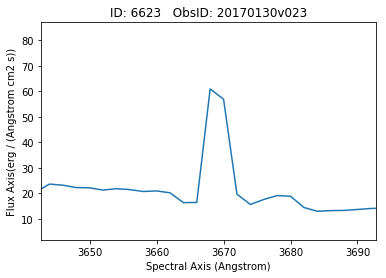

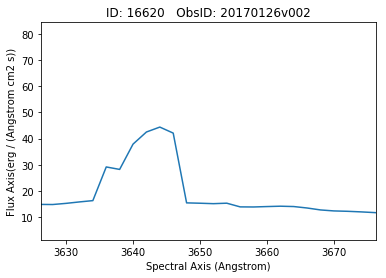

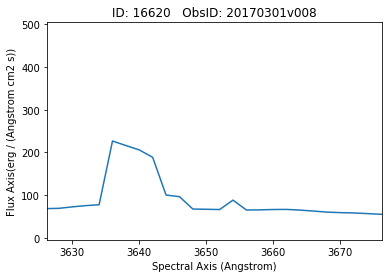

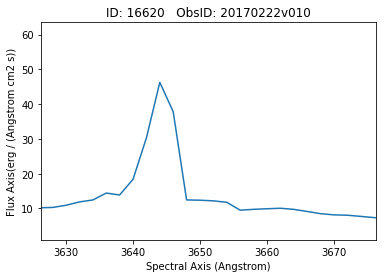

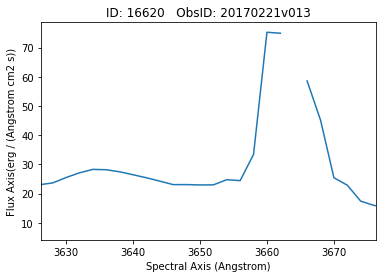

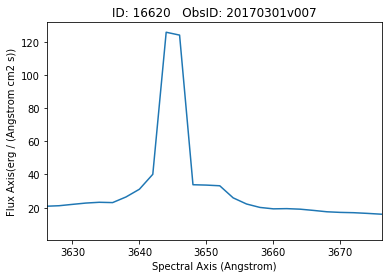

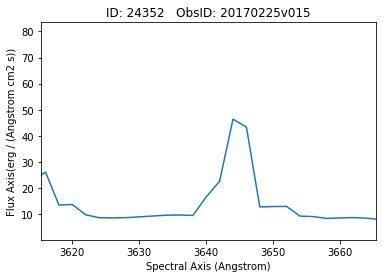

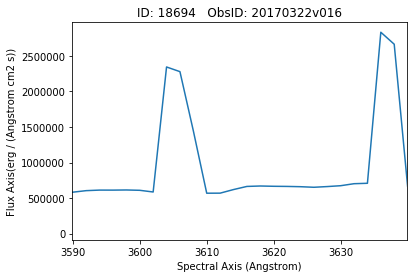

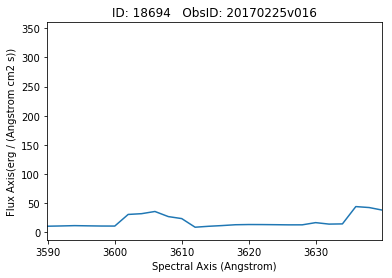

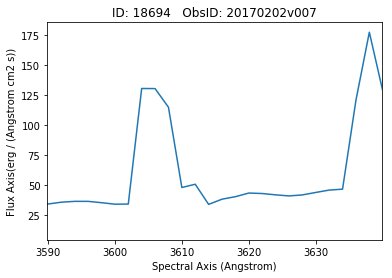

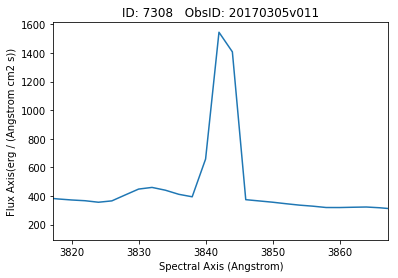

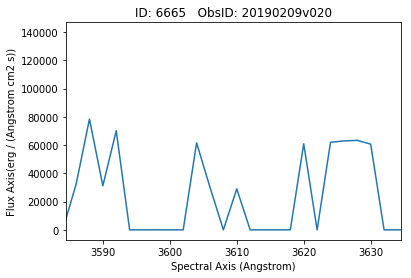

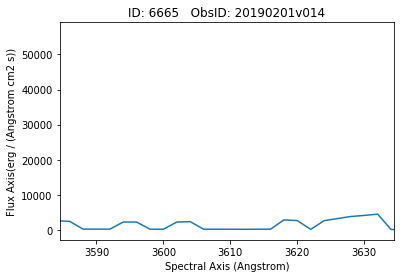

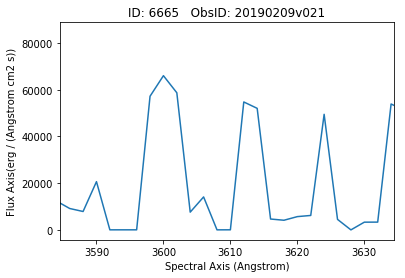

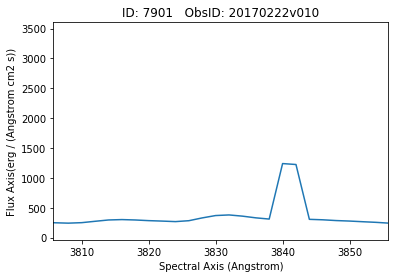

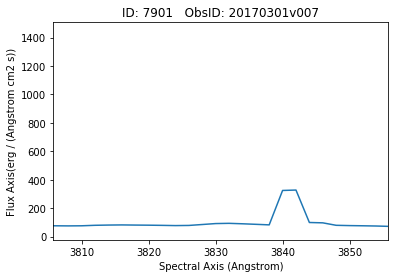

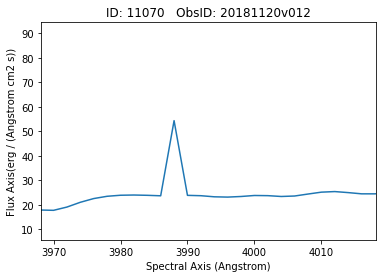

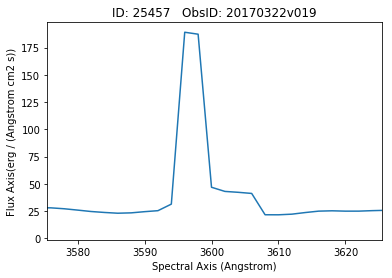

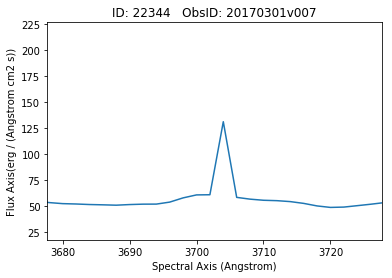

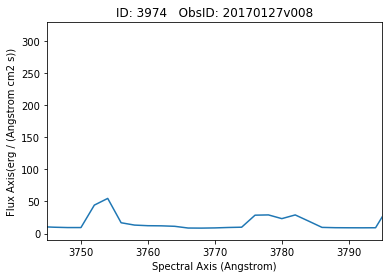

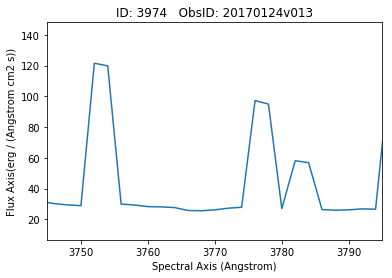

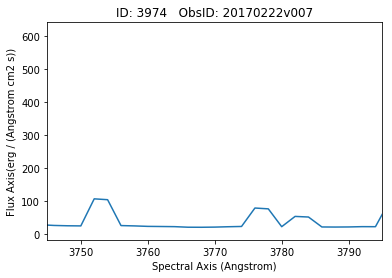

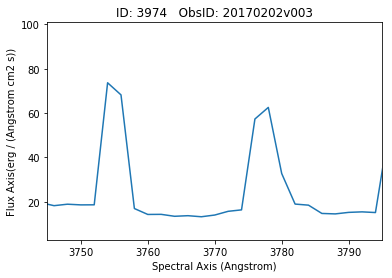

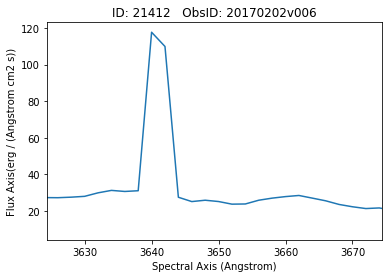

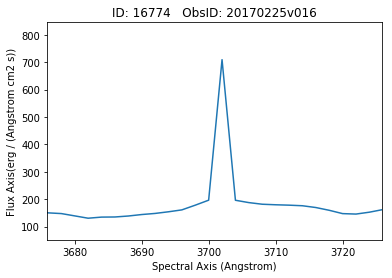

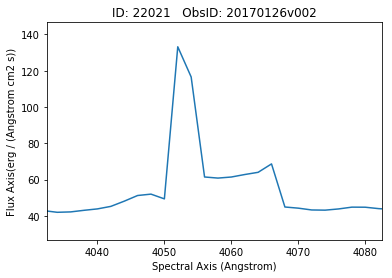

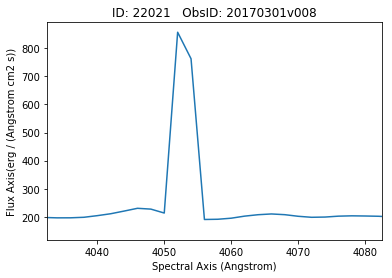

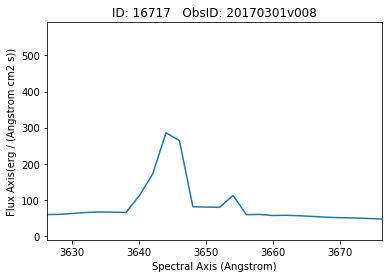

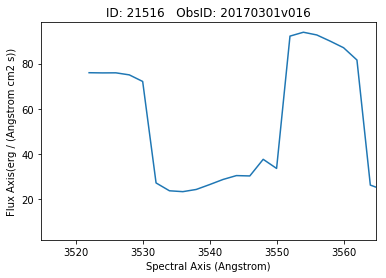

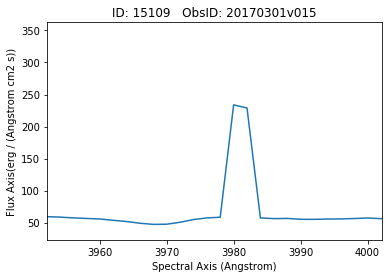

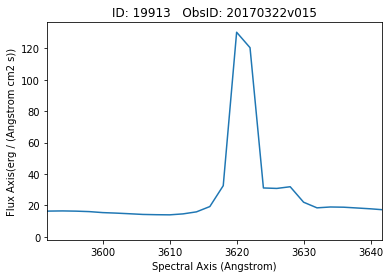

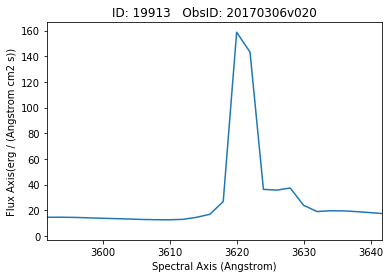

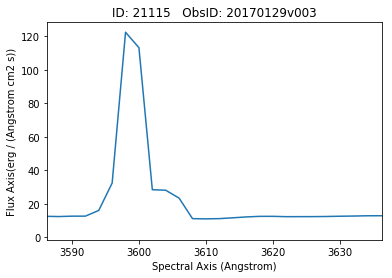

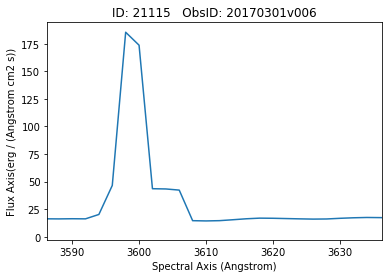

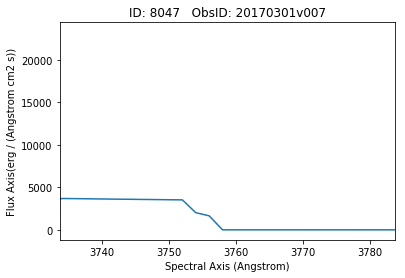

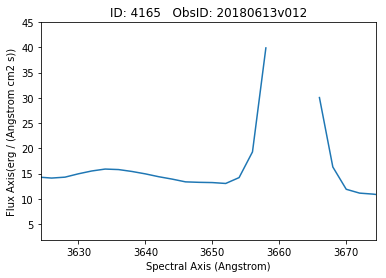

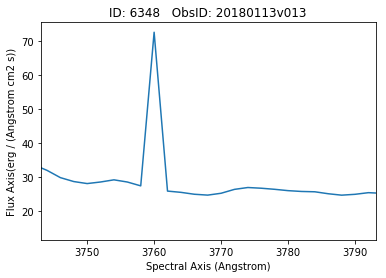

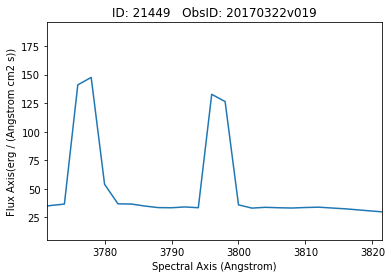

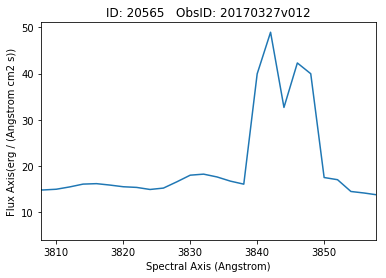

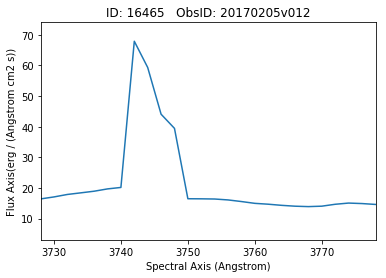

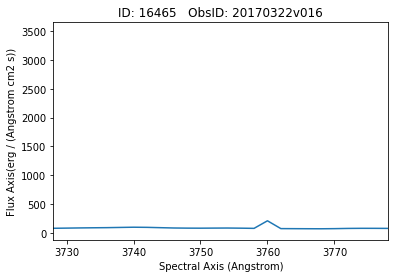

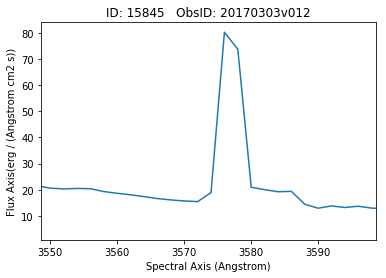

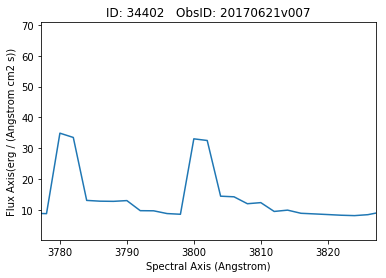

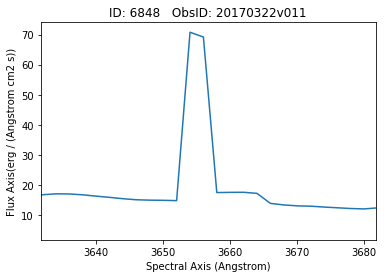

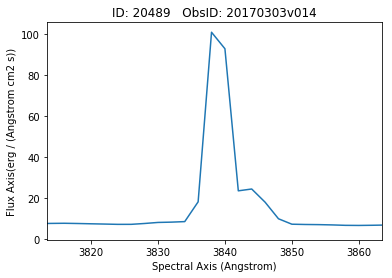

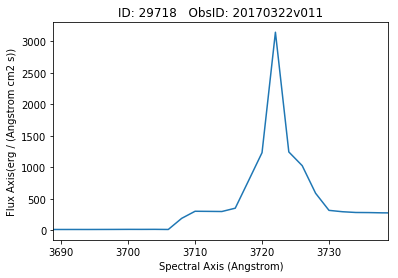

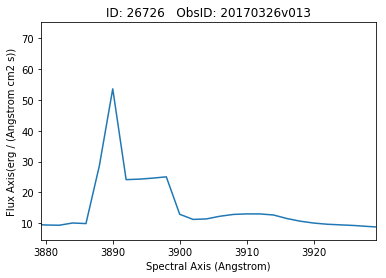

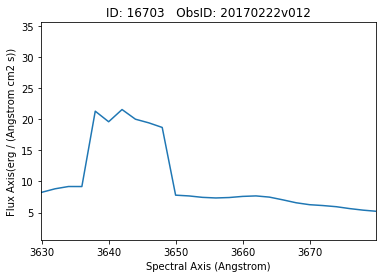

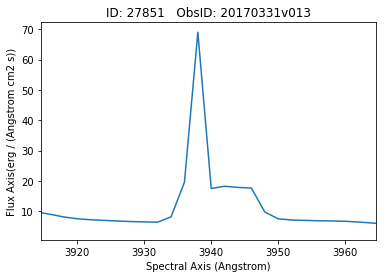

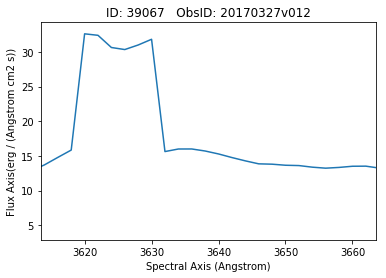

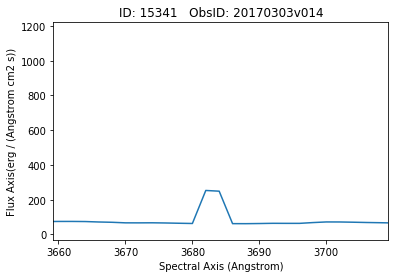

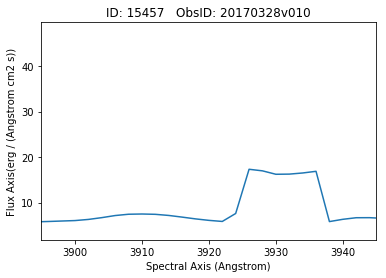

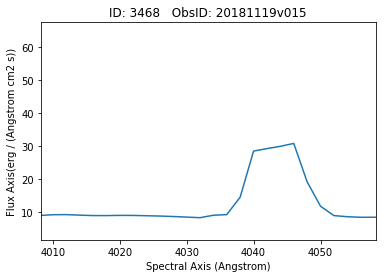

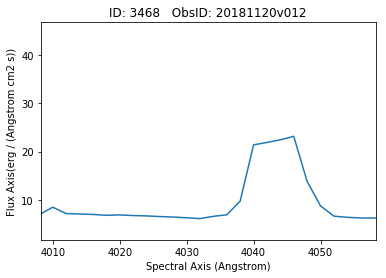

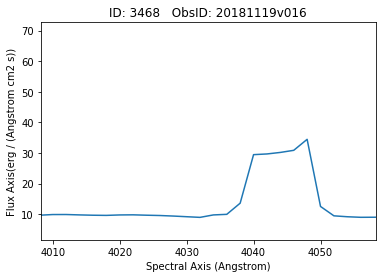

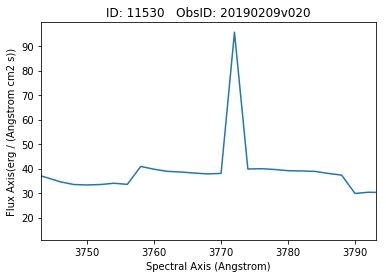

In [12]:
count = 0
for obj in Sources.keys():
    for datevobs in Sources[obj].keys():
        count += 1
        line_fit( obj, datevobs) # note could use multiprocessing Pool to really speed this up

In [17]:
log.info("Source dictionary contains %s extractions" % count)

[INFO - 2019-07-05 11:43:47,748] Source dictionary contains 5233 extractions
INFO:input_utils:Source dictionary contains 5233 extractions
